In [1]:
# Import necessary libraries
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Login to wandb (if not already logged in)
wandb.login()

# Define the project and entity
project_name = "Negatives"
entity_name = "ntourne"

# Initialize the wandb API
api = wandb.Api()

# Fetch all runs from the project
runs = api.runs(f"{entity_name}/{project_name}")

wandb: Currently logged in as: ntourne to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
# Initialize a list to store results
results = []

# Iterate through runs and extract metrics
for run in runs:
    # Get the summary metrics, config, and name of the run
    summary = run.summary._json_dict
    config = run.config
    name = run.name
    
    # Combine the data into a single dictionary
    run_data = {
        "run_name": name,
        "TF": config.get("TF"),
        "celltype": config.get("celltype"),
        "neg_mode": config.get("neg_mode"),
        "cross_val_set": config.get("cross_val_set"),
        "group_name": config.get("group_name"),
        "AUROC": summary.get("test_AUROC"),
        "AUROC_HQ": summary.get("test_AUROC_HQ"),
        "val_loss": summary.get("val_loss"),
    }
    results.append(run_data)

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

In [3]:
results_df = pd.DataFrame(results)
results_df = results_df[results_df['group_name'].isin(["full_run_2", "full_run_2_ct"])]
HQ_results = pd.DataFrame(results)
HQ_results = HQ_results[HQ_results['group_name'] == "full_run_3_HQ"]
HQ_results["neg_mode"] = "HQ training"
HQ_results = HQ_results.rename(columns={"AUROC": "AUROC_HQ", "AUROC_HQ": "AUROC"})
HQ_results = HQ_results[HQ_results['celltype'].isin(['A549', 'GM12878', 'K562', 'HepG2'])]
# Merge results_df with HQ_results, aligning columns as needed
results_df = pd.concat([results_df, HQ_results], ignore_index=True)

In [4]:
# Exclude rows where neg_mode is 'HQ training' before checking for NaNs in AUROC
mask = results_df["neg_mode"] != "HQ training"
num_nans = results_df.loc[mask, "AUROC"].isna().sum()
print(f"Number of NaNs in AUROC (excluding HQ training): {num_nans}")
results_df.loc[mask & results_df["AUROC"].isna()]

Number of NaNs in AUROC (excluding HQ training): 1


,run_name,TF,celltype,neg_mode,cross_val_set,group_name,AUROC,AUROC_HQ,val_loss
1679,hardy-star-6843,TCF12,HepG2,neighbors,5.0,full_run_2,NaN,NaN,0.777954


Weird, on wandb it does have test AUROC and AUROC_HQ

In [5]:
# Filter out entries where AUROC_HQ == 0 -> probably an issue with the cross val split 
filtered_out_count = results_df[(results_df['AUROC_HQ'] == 0) | (results_df['AUROC_HQ'].isna())].shape[0]

# Filter the DataFrame to exclude these entries
results_df = results_df[~((results_df['AUROC_HQ'] == 0) | (results_df['AUROC_HQ'].isna()))]

# Print the count of filtered-out entries
print(f"Number of entries where AUROC_HQ == 0 or NaN: {filtered_out_count}")

Number of entries where AUROC_HQ == 0 or NaN: 1


In [6]:
results_df[(results_df['AUROC_HQ'] == 1)]

,run_name,TF,celltype,neg_mode,cross_val_set,group_name,AUROC,AUROC_HQ,val_loss


In [7]:
results_df["TF"].value_counts() # this doesn't work now because there are multiple celltypes

TF
CTCF                   192
YY1_(SC-281)           144
Max                    144
ELF1_(SC-631)          144
USF-1                  144
ATF3                   144
ZBTB33                 144
SIX5                   108
SRF                    108
RFX5_(200-401-194)     108
SP1                    108
USF2                   108
MAZ_(ab85725)          108
CEBPB_(SC-150)         108
ETS1                   108
Mxi1_(AF4185)          108
TBP                    108
ZNF274                 108
Nrf1                   108
JunD                   108
TCF12                  107
TCF7L2                  84
Znf143_(16618-1-AP)     72
Egr-1                   72
ELK1_(1277-1)           72
BHLHE40                 72
TEAD4_(SC-101184)       72
NFIC_(SC-81335)         72
NF-YA                   72
FOXA1_(SC-101058)       72
MEF2A                   72
NF-YB                   72
STAT5A_(SC-74442)       72
MafK_(ab50322)          72
RXRA                    72
FOSL2                   72
MafF_(M8194)            7

In [8]:
results_df["celltype_TF"] = results_df["celltype"]+"_"+results_df["TF"]

In [9]:
output = results_df["celltype_TF"].value_counts() # this doesn't work now because there are multiple celltypes

In [10]:
output.to_dict()

{'GM12878_CTCF': 36,
 'GM12878_YY1_(SC-281)': 36,
 'GM12878_SRF': 36,
 'GM12878_Mxi1_(AF4185)': 36,
 'GM12878_Egr-1': 36,
 'GM12878_TBP': 36,
 'GM12878_MAZ_(ab85725)': 36,
 'GM12878_ELK1_(1277-1)': 36,
 'GM12878_SIX5': 36,
 'GM12878_USF-1': 36,
 'GM12878_ATF2_(SC-81188)': 36,
 'GM12878_ELF1_(SC-631)': 36,
 'GM12878_RFX5_(200-401-194)': 36,
 'GM12878_SP1': 36,
 'GM12878_Pbx3': 36,
 'GM12878_MEF2A': 36,
 'GM12878_TCF12': 36,
 'GM12878_Max': 36,
 'GM12878_NF-YB': 36,
 'GM12878_USF2': 36,
 'GM12878_Znf143_(16618-1-AP)': 36,
 'GM12878_ZEB1_(SC-25388)': 36,
 'GM12878_STAT5A_(SC-74442)': 36,
 'GM12878_NFIC_(SC-81335)': 36,
 'GM12878_Nrf1': 36,
 'GM12878_CEBPB_(SC-150)': 36,
 'GM12878_ETS1': 36,
 'GM12878_ZBTB33': 36,
 'GM12878_RXRA': 36,
 'GM12878_FOXM1_(SC-502)': 36,
 'HepG2_MafF_(M8194)': 36,
 'HepG2_FOSL2': 36,
 'HepG2_YY1_(SC-281)': 36,
 'HepG2_JunD': 36,
 'GM12878_ATF3': 36,
 'GM12878_NF-YA': 36,
 'GM12878_IKZF1_(IkN)_(UCLA)': 36,
 'GM12878_JunD': 36,
 'GM12878_ZZZ3': 36,
 'GM12878_ZNF27

In [11]:
# Filter out TFs with less than 24 samples
results_df = results_df.groupby('celltype_TF').filter(lambda x: len(x) >= 36) #! ONLY TAKE THE 4 BIG CELL TYPES

In [12]:
results_df["celltype"].value_counts() 

celltype
GM12878    1296
K562       1296
HepG2      1188
A549        504
Name: count, dtype: int64

In [13]:
results_df["TF-neg_mode"] = results_df["TF"]+"_"+results_df["neg_mode"]
results_df["TF-neg_mode-celltype"] = results_df["TF"]+"_"+results_df["neg_mode"]+"_"+results_df["celltype"]

Now looking at the difference between HQ and normal AUROC. Best done per cell type because there is too much data!


In [14]:
tf_per_celltype = results_df.groupby("celltype")["TF"].nunique()
print(tf_per_celltype)

celltype
A549       14
GM12878    36
HepG2      33
K562       36
Name: TF, dtype: int64


In [15]:
results_df["neg_mode"].value_counts()

neg_mode
dinucl_sampled     714
dinucl_shuffled    714
shuffled           714
neighbors          714
celltype           714
HQ training        714
Name: count, dtype: int64

In [16]:
# Group by celltype, TF, and neg_mode, then calculate variance of AUROC_HQ across cross_val_set
auroc_hq_var = results_df.groupby(['celltype', 'TF', 'neg_mode'])['AUROC_HQ'].var().reset_index()
auroc_hq_var = auroc_hq_var.rename(columns={'AUROC_HQ': 'AUROC_HQ_variance'})
auroc_hq_var

,celltype,TF,neg_mode,AUROC_HQ_variance
0,A549,ATF3,HQ training,0.000451
1,A549,ATF3,celltype,0.001299
2,A549,ATF3,dinucl_sampled,0.000473
3,A549,ATF3,dinucl_shuffled,0.000835
4,A549,ATF3,neighbors,0.002470
...,...,...,...,...
709,K562,Znf143_(16618-1-AP),celltype,0.001234
710,K562,Znf143_(16618-1-AP),dinucl_sampled,0.000791
711,K562,Znf143_(16618-1-AP),dinucl_shuffled,0.001010
712,K562,Znf143_(16618-1-AP),neighbors,0.003491


In [17]:
results_df

,run_name,TF,celltype,neg_mode,cross_val_set,group_name,AUROC,AUROC_HQ,val_loss,celltype_TF,TF-neg_mode,TF-neg_mode-celltype
96,clear-shape-5260,CTCF,GM12878,dinucl_sampled,0.0,full_run_2,0.969141,0.952979,0.426934,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878
97,driven-rain-5261,CTCF,GM12878,dinucl_sampled,1.0,full_run_2,0.961291,0.925307,0.522846,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878
98,dandy-serenity-5262,CTCF,GM12878,dinucl_sampled,2.0,full_run_2,0.975019,0.960630,0.426776,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878
99,good-thunder-5263,CTCF,GM12878,dinucl_sampled,3.0,full_run_2,0.968358,0.928841,0.440390,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878
100,whole-pond-5264,CTCF,GM12878,dinucl_sampled,4.0,full_run_2,0.980562,0.963547,0.215077,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878
...,...,...,...,...,...,...,...,...,...,...,...,...
4459,A549_FOXA1_(SC-101058)_CV1_20250619_02:36,FOXA1_(SC-101058),A549,HQ training,1.0,full_run_3_HQ,NaN,0.907562,0.457816,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549
4460,A549_FOXA1_(SC-101058)_CV2_20250619_02:36,FOXA1_(SC-101058),A549,HQ training,2.0,full_run_3_HQ,NaN,0.902594,0.542374,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549
4461,A549_FOXA1_(SC-101058)_CV3_20250619_02:36,FOXA1_(SC-101058),A549,HQ training,3.0,full_run_3_HQ,NaN,0.912508,0.418853,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549
4462,A549_FOXA1_(SC-101058)_CV4_20250619_02:37,FOXA1_(SC-101058),A549,HQ training,4.0,full_run_3_HQ,NaN,0.912237,0.496110,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549


/tmp/ipykernel_4150194/2633052359.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_4150194/2633052359.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


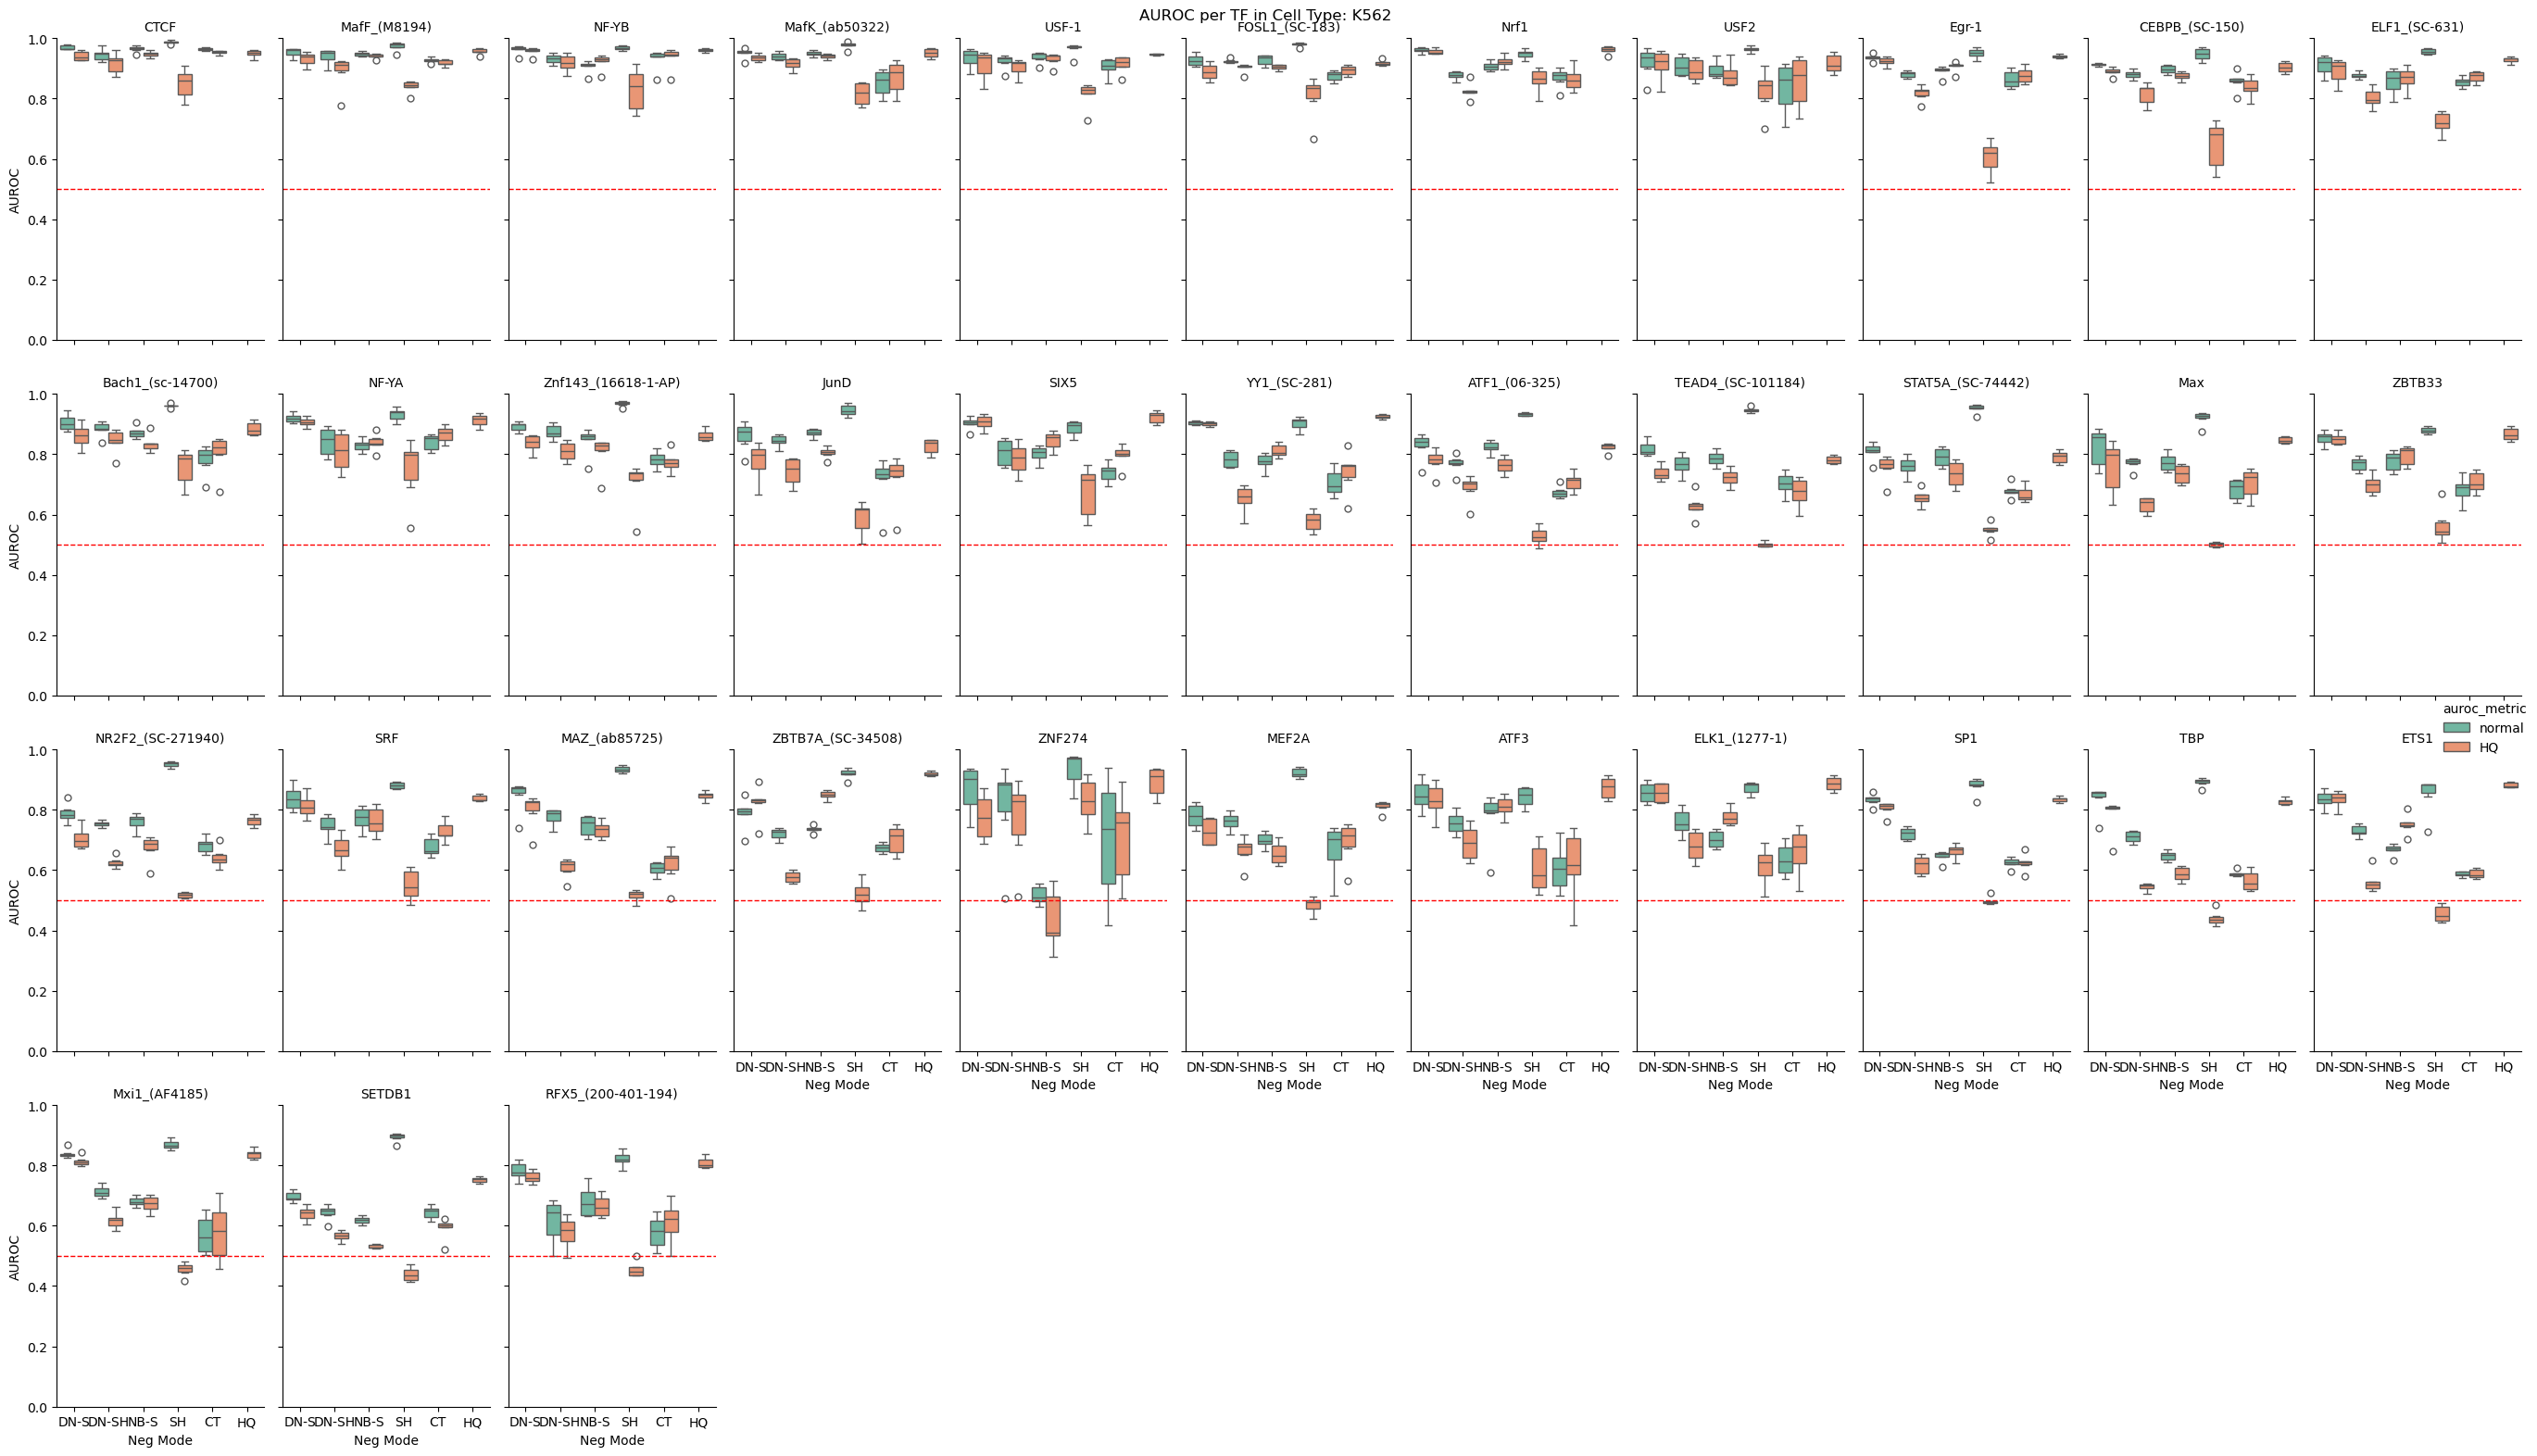

In [18]:
celltype = "K562"
# Filter the DataFrame for the current cell type
celltype_df = results_df[results_df['celltype'] == celltype]
mean_auroc_per_tf = celltype_df.groupby('TF')['AUROC'].mean().sort_values(ascending=False)
tf_order = mean_auroc_per_tf.index.tolist()

# Create a custom order for neg_sampling types
neg_sampling_order = ['dinucl_sampled', 'dinucl_shuffled', 'neighbors', 'shuffled', "celltype", "HQ training"]

# Sort the DataFrame by TF (using the custom order) and neg_sampling type
celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)
celltype_df = celltype_df.sort_values(['TF', 'neg_mode'])

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    celltype_df.sort_values(by=['TF', 'neg_mode']),
    id_vars=['TF', 'neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})

# Shorten neg_mode labels
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH',
    'celltype': 'CT',
    'HQ training': 'HQ'
}

# Apply and order short labels
melted_df['neg_mode_short'] = melted_df['neg_mode'].map(neg_mode_labels)
neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH', 'CT', 'HQ']
melted_df['neg_mode_short'] = pd.Categorical(melted_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

# Create the catplot
g = sns.catplot(
    data=melted_df,
    x='neg_mode_short',
    col='TF',
    y='AUROC_value',
    hue='auroc_metric',
    kind='box',
    col_wrap=11,
    height=4,
    aspect=0.6,
    palette='Set2'
)
g.set(ylim=(0, 1))
for ax in g.axes.flatten():
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
# Titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Neg Mode", "AUROC")

# Fix x-tick rotation manually
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)
#     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
g.fig.suptitle(f"AUROC per TF in Cell Type: {celltype}")
plt.tight_layout()
plt.show()


/tmp/ipykernel_4150194/915112829.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_4150194/915112829.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


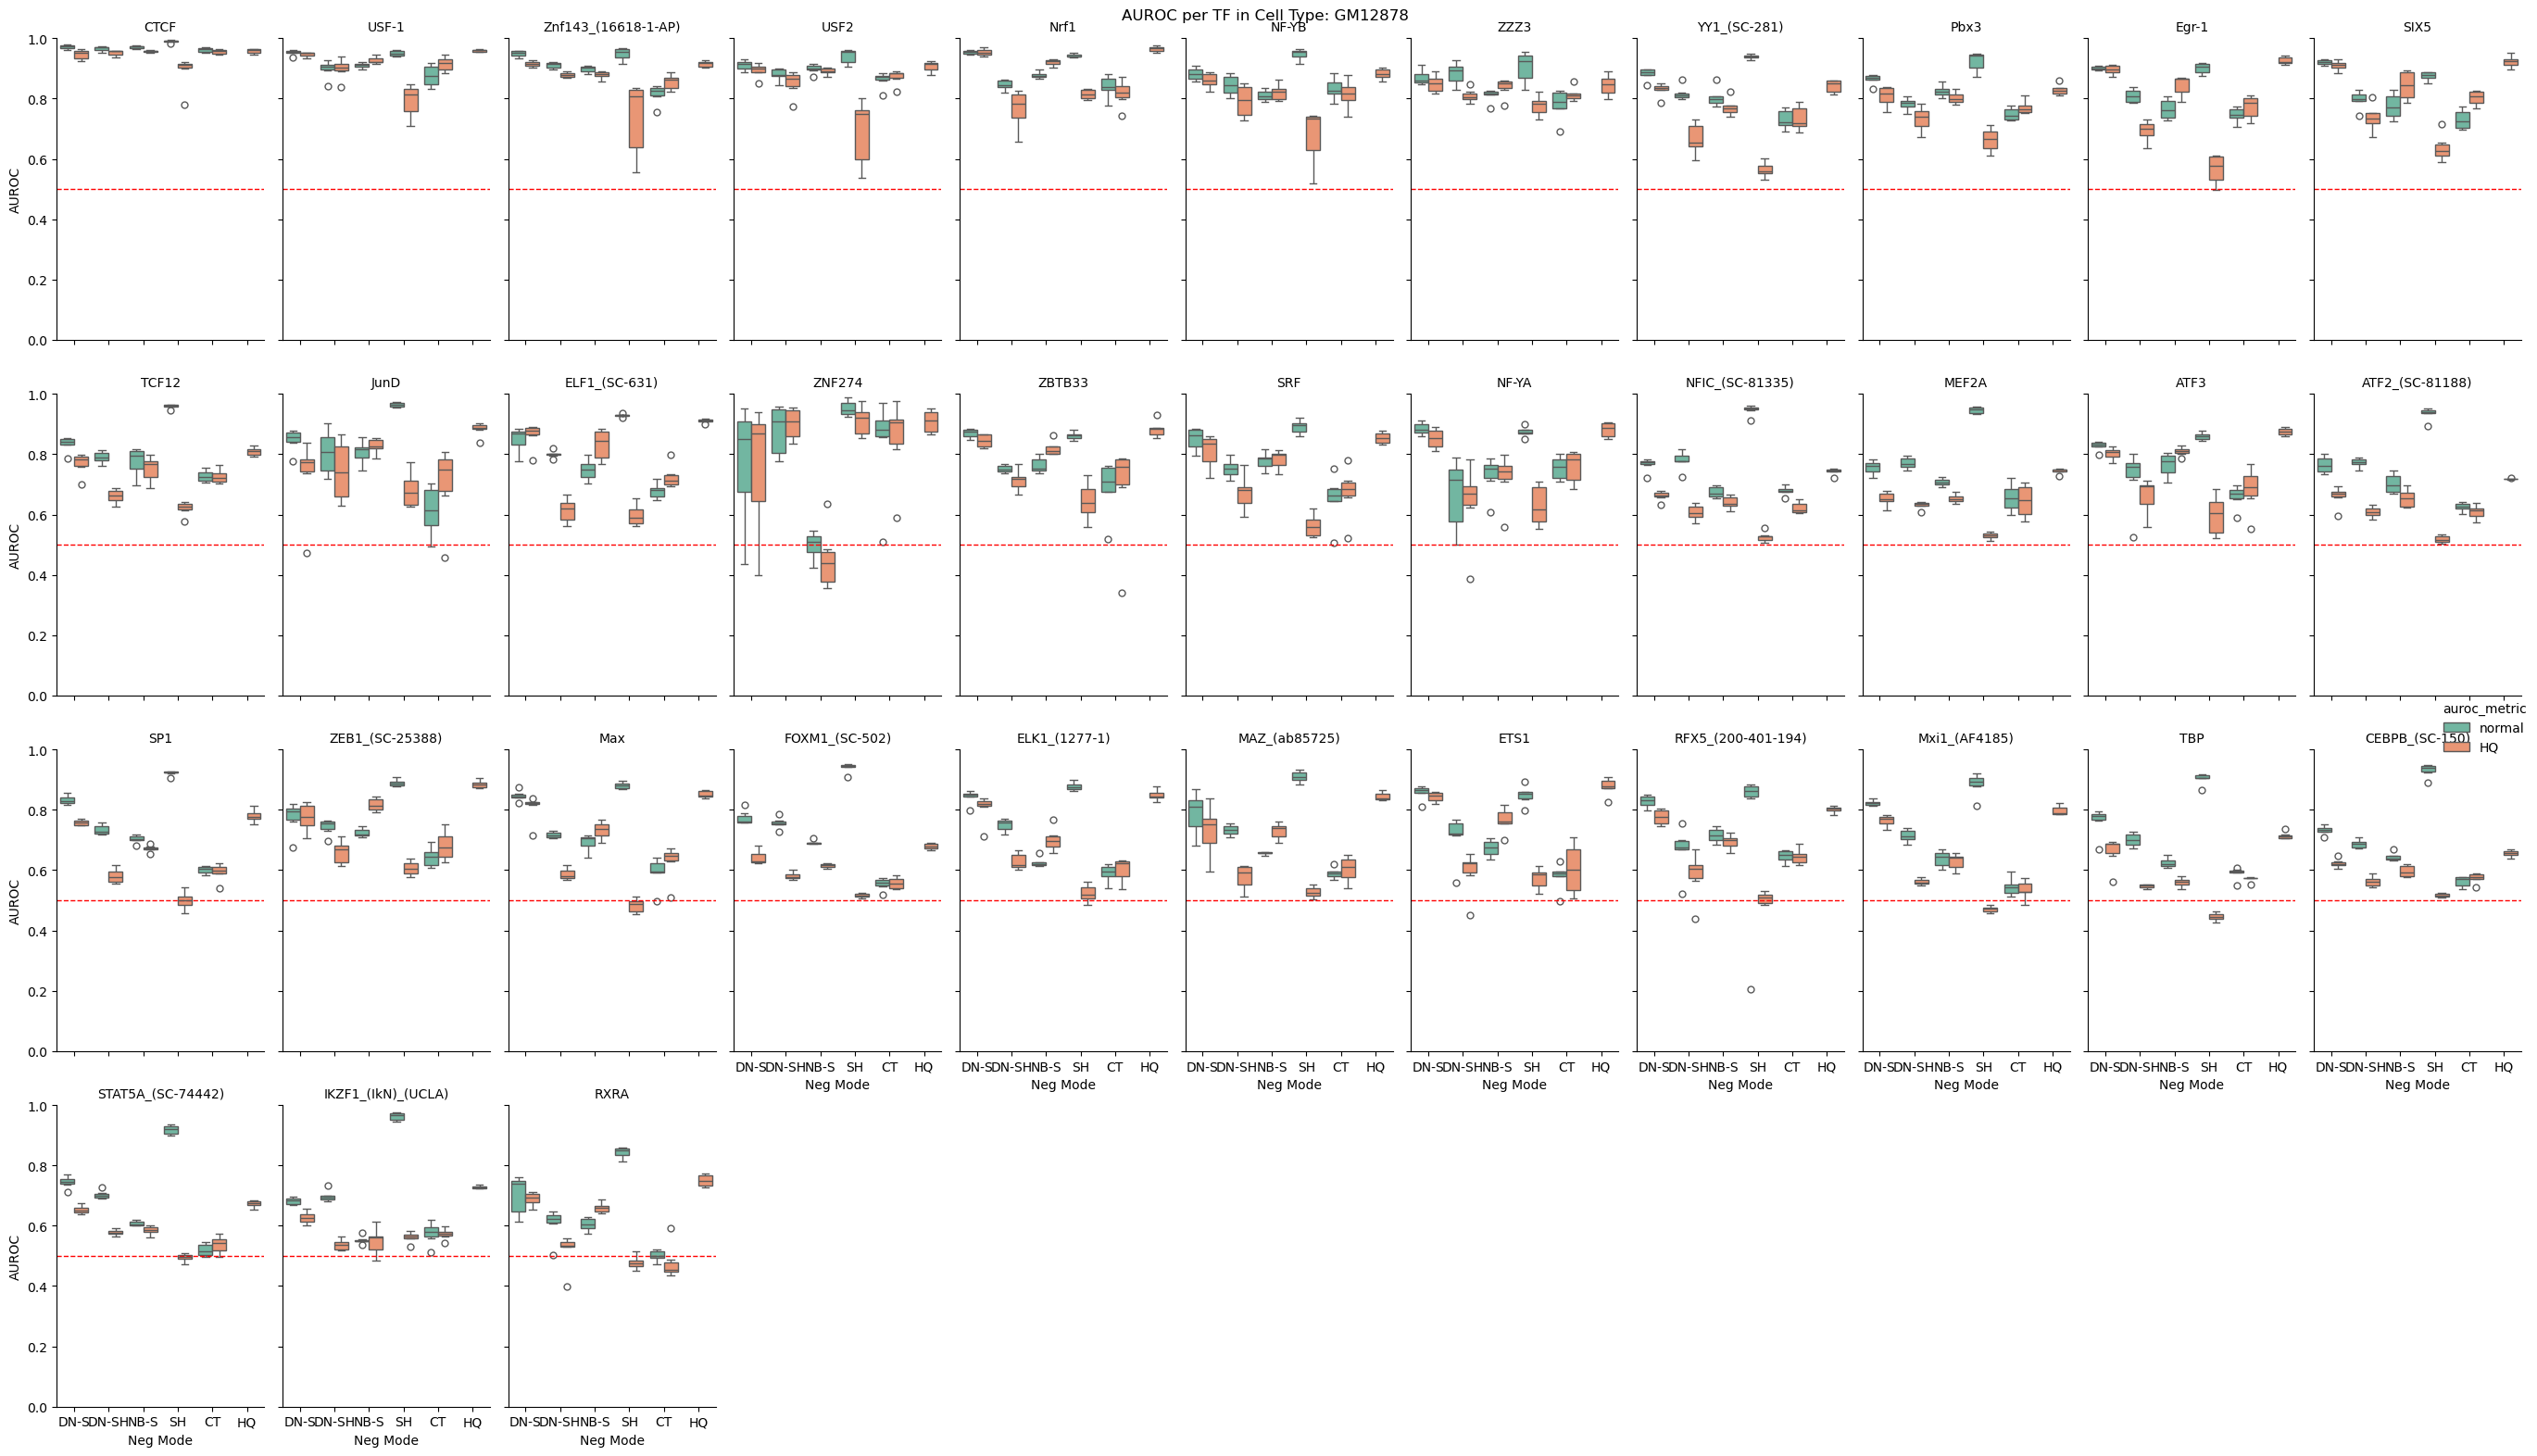

In [19]:
celltype = "GM12878"
# Filter the DataFrame for the current cell type
celltype_df = results_df[results_df['celltype'] == celltype]
mean_auroc_per_tf = celltype_df.groupby('TF')['AUROC'].mean().sort_values(ascending=False)
tf_order = mean_auroc_per_tf.index.tolist()

# Create a custom order for neg_sampling types
neg_sampling_order = ['dinucl_sampled', 'dinucl_shuffled', 'neighbors', 'shuffled', "celltype", "HQ training"]

# Sort the DataFrame by TF (using the custom order) and neg_sampling type
celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)
celltype_df = celltype_df.sort_values(['TF', 'neg_mode'])

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    celltype_df.sort_values(by=['TF', 'neg_mode']),
    id_vars=['TF', 'neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})

# Shorten neg_mode labels
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH',
    'celltype': 'CT',
    'HQ training': 'HQ'
}

# Apply and order short labels
melted_df['neg_mode_short'] = melted_df['neg_mode'].map(neg_mode_labels)
neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH', 'CT', 'HQ']
melted_df['neg_mode_short'] = pd.Categorical(melted_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

# Create the catplot
g = sns.catplot(
    data=melted_df,
    x='neg_mode_short',
    col='TF',
    y='AUROC_value',
    hue='auroc_metric',
    kind='box',
    col_wrap=11,
    height=4,
    aspect=0.6,
    palette='Set2'
)
g.set(ylim=(0, 1))
for ax in g.axes.flatten():
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
# Titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Neg Mode", "AUROC")

# Fix x-tick rotation manually
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)
#     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
g.fig.suptitle(f"AUROC per TF in Cell Type: {celltype}")
plt.tight_layout()
plt.show()



/tmp/ipykernel_4150194/890733880.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_4150194/890733880.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


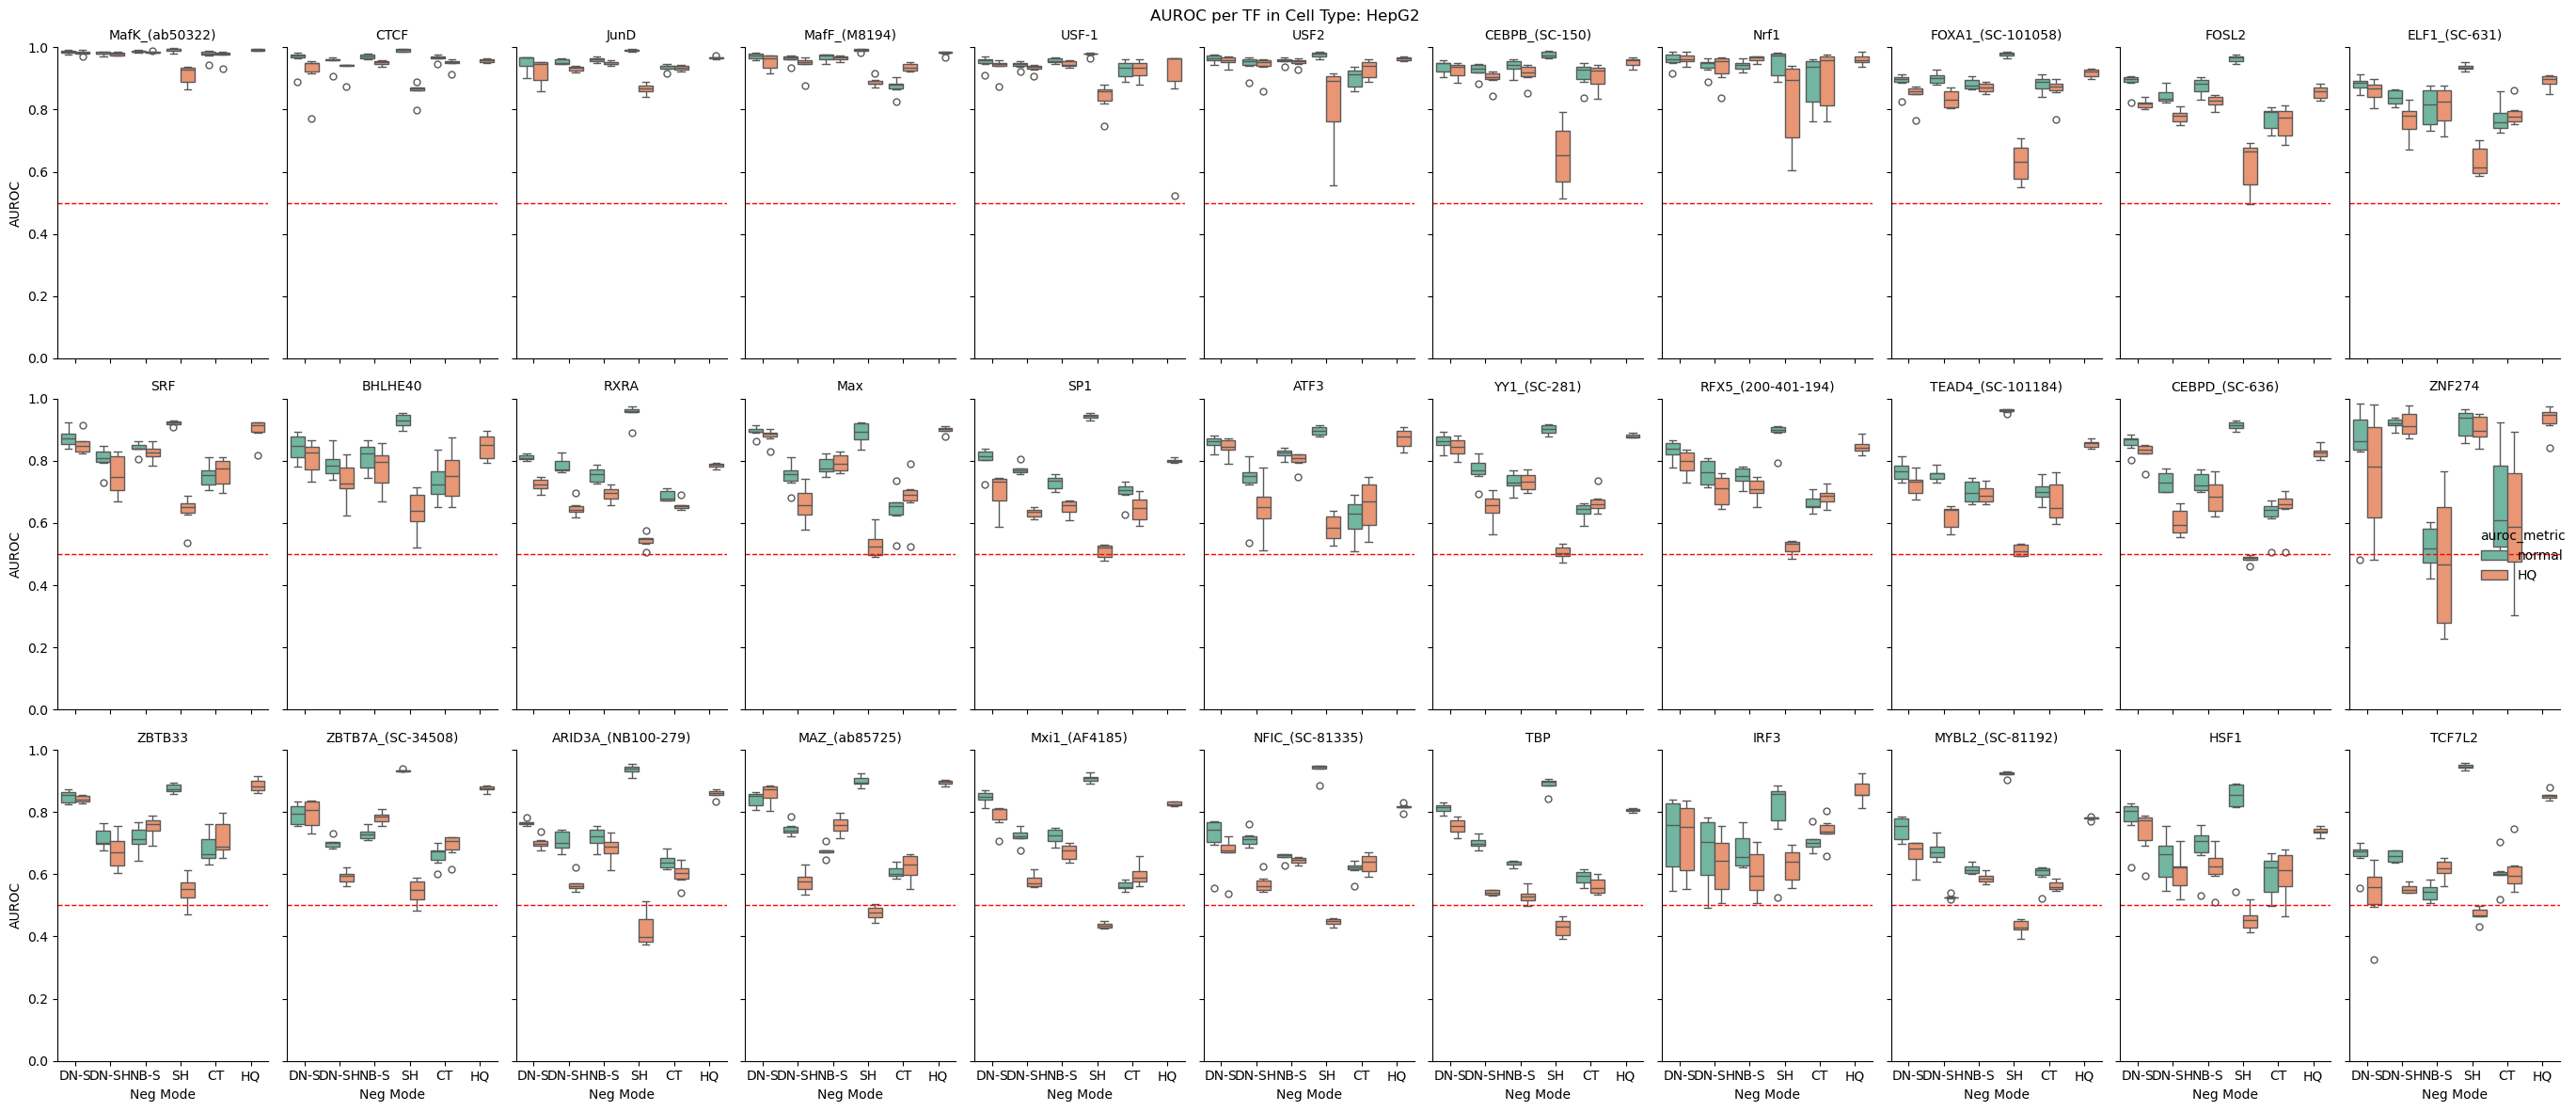

In [20]:
celltype = "HepG2"
# Filter the DataFrame for the current cell type
celltype_df = results_df[results_df['celltype'] == celltype]
mean_auroc_per_tf = celltype_df.groupby('TF')['AUROC'].mean().sort_values(ascending=False)
tf_order = mean_auroc_per_tf.index.tolist()

# Create a custom order for neg_sampling types
neg_sampling_order = ['dinucl_sampled', 'dinucl_shuffled', 'neighbors', 'shuffled', "celltype", "HQ training"]

# Sort the DataFrame by TF (using the custom order) and neg_sampling type
celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)
celltype_df = celltype_df.sort_values(['TF', 'neg_mode'])

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    celltype_df.sort_values(by=['TF', 'neg_mode']),
    id_vars=['TF', 'neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})

# Shorten neg_mode labels
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH',
    'celltype': 'CT',
    'HQ training': 'HQ'
}

# Apply and order short labels
melted_df['neg_mode_short'] = melted_df['neg_mode'].map(neg_mode_labels)
neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH', 'CT', 'HQ']
melted_df['neg_mode_short'] = pd.Categorical(melted_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

# Create the catplot
g = sns.catplot(
    data=melted_df,
    x='neg_mode_short',
    col='TF',
    y='AUROC_value',
    hue='auroc_metric',
    kind='box',
    col_wrap=11,
    height=4,
    aspect=0.6,
    palette='Set2'
)
g.set(ylim=(0, 1))
for ax in g.axes.flatten():
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
# Titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Neg Mode", "AUROC")

# Fix x-tick rotation manually
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)
#     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
g.fig.suptitle(f"AUROC per TF in Cell Type: {celltype}")
plt.tight_layout()
plt.show()



/tmp/ipykernel_4150194/1469650766.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_4150194/1469650766.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


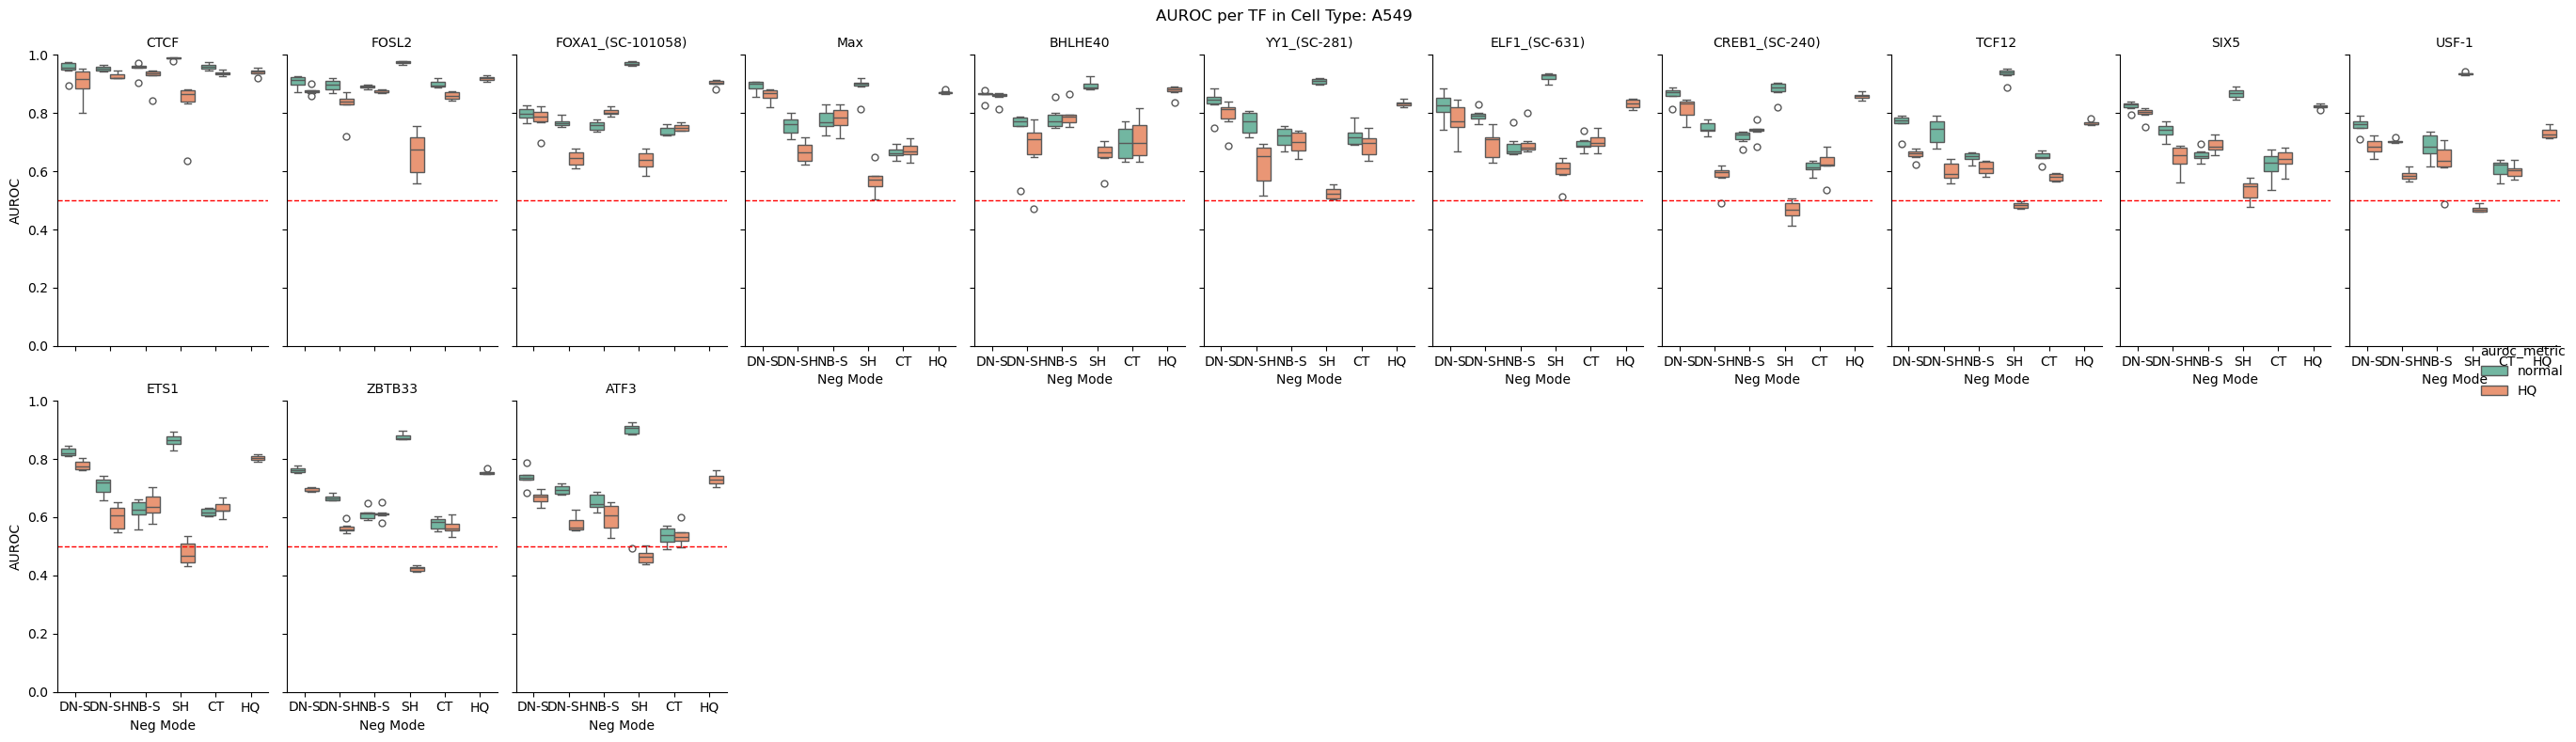

In [21]:
celltype = "A549"
# Filter the DataFrame for the current cell type
celltype_df = results_df[results_df['celltype'] == celltype]
mean_auroc_per_tf = celltype_df.groupby('TF')['AUROC'].mean().sort_values(ascending=False)
tf_order = mean_auroc_per_tf.index.tolist()

# Create a custom order for neg_sampling types
neg_sampling_order = ['dinucl_sampled', 'dinucl_shuffled', 'neighbors', 'shuffled', "celltype", "HQ training"]

# Sort the DataFrame by TF (using the custom order) and neg_sampling type
celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)
celltype_df = celltype_df.sort_values(['TF', 'neg_mode'])

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    celltype_df.sort_values(by=['TF', 'neg_mode']),
    id_vars=['TF', 'neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})

# Shorten neg_mode labels
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH',
    'celltype': 'CT',
    'HQ training': 'HQ'
}

# Apply and order short labels
melted_df['neg_mode_short'] = melted_df['neg_mode'].map(neg_mode_labels)
neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH', 'CT', 'HQ']
melted_df['neg_mode_short'] = pd.Categorical(melted_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

# Create the catplot
g = sns.catplot(
    data=melted_df,
    x='neg_mode_short',
    col='TF',
    y='AUROC_value',
    hue='auroc_metric',
    kind='box',
    col_wrap=11,
    height=4,
    aspect=0.6,
    palette='Set2'
)
g.set(ylim=(0, 1))
for ax in g.axes.flatten():
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
# Titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Neg Mode", "AUROC")

# Fix x-tick rotation manually
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)
#     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
g.fig.suptitle(f"AUROC per TF in Cell Type: {celltype}")
plt.tight_layout()
plt.show()



In [22]:
results_df["AUROC_delta"] = results_df["AUROC"] - results_df["AUROC_HQ"]

/tmp/ipykernel_4150194/3202167321.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_4150194/3202167321.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


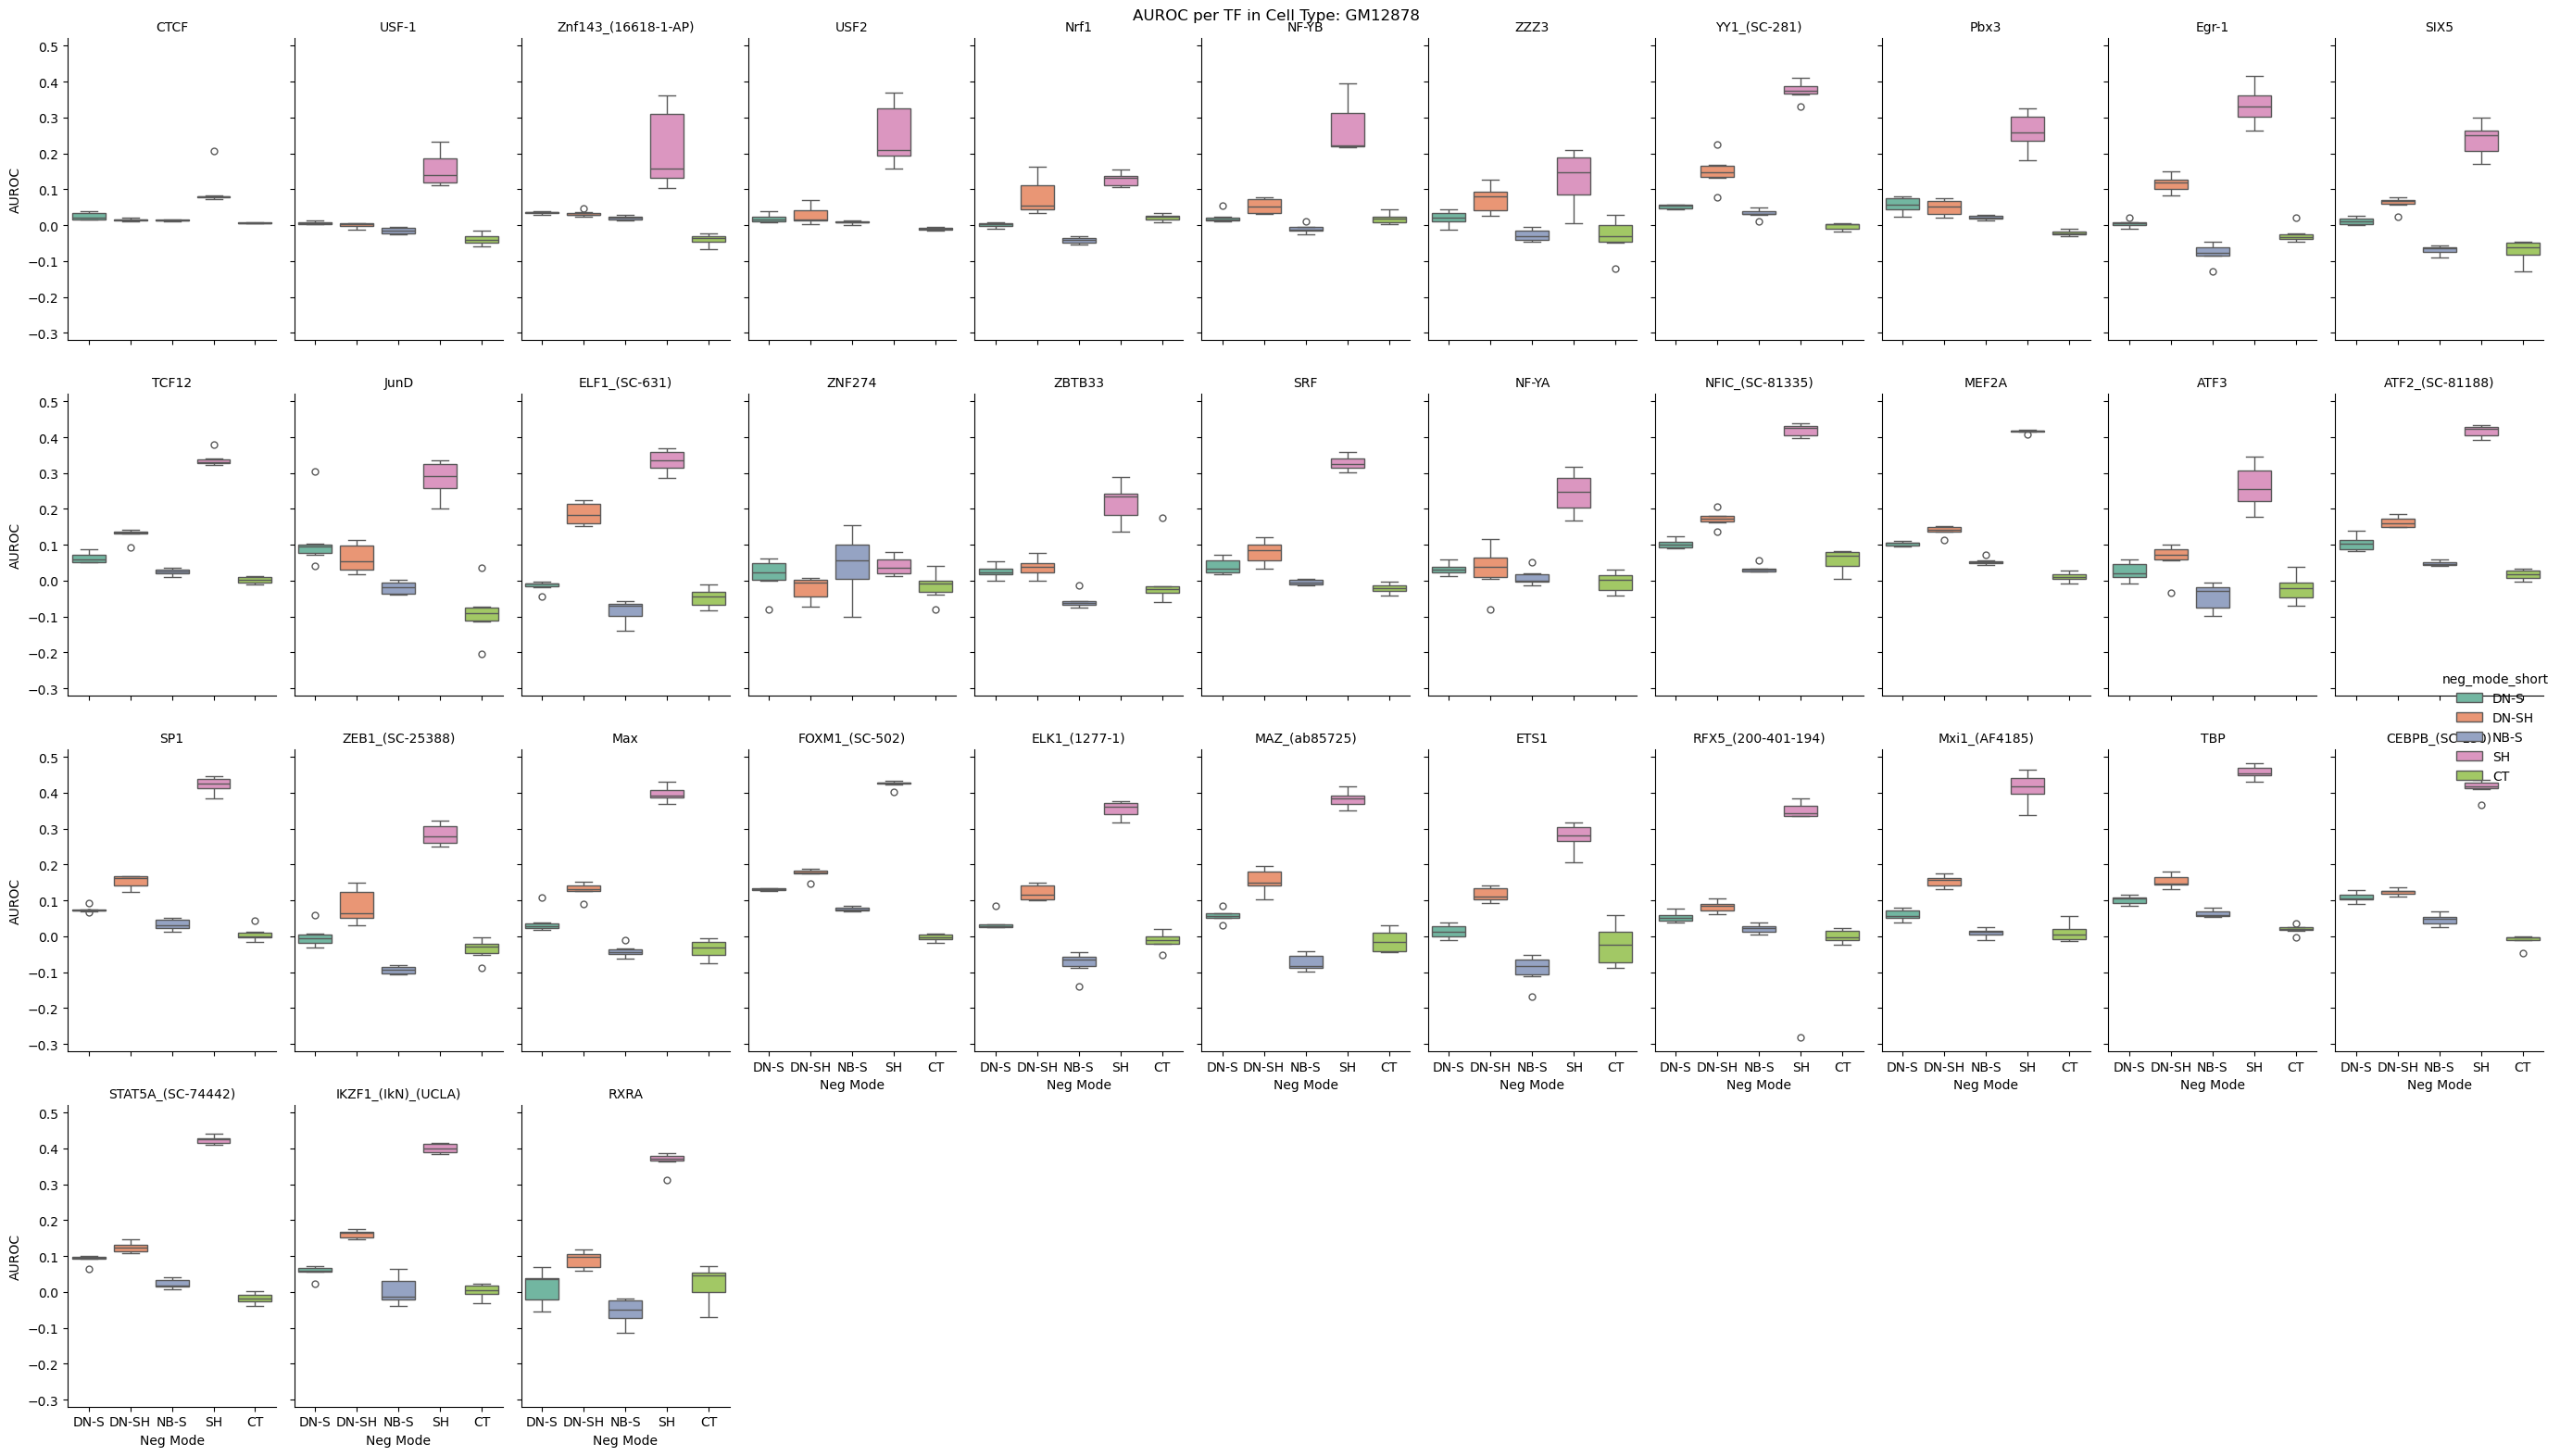

/tmp/ipykernel_4150194/3202167321.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_4150194/3202167321.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


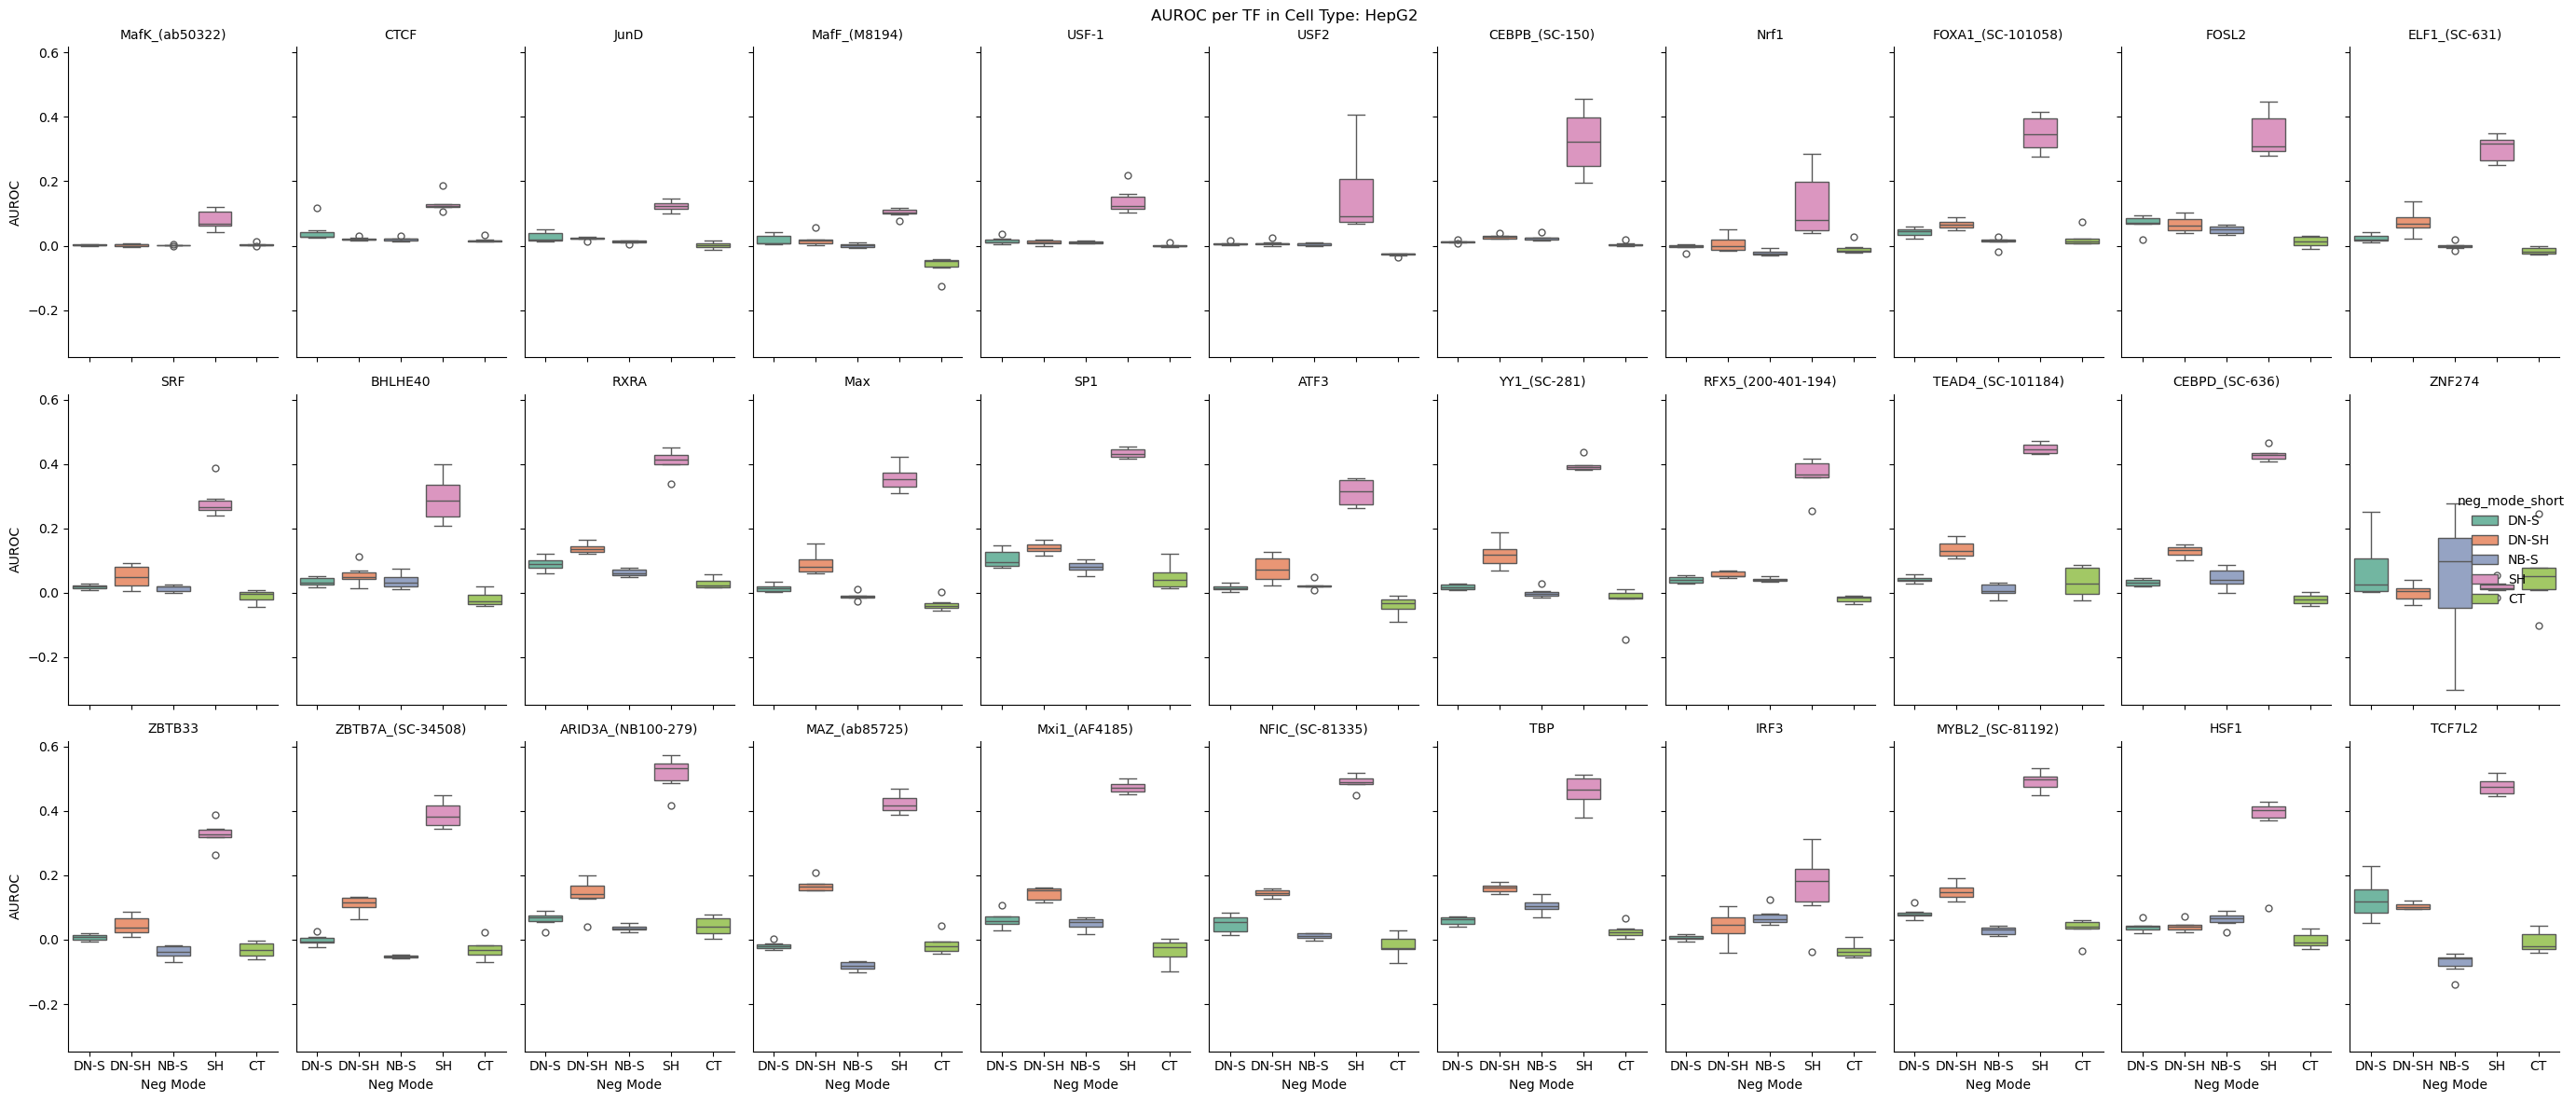

/tmp/ipykernel_4150194/3202167321.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_4150194/3202167321.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


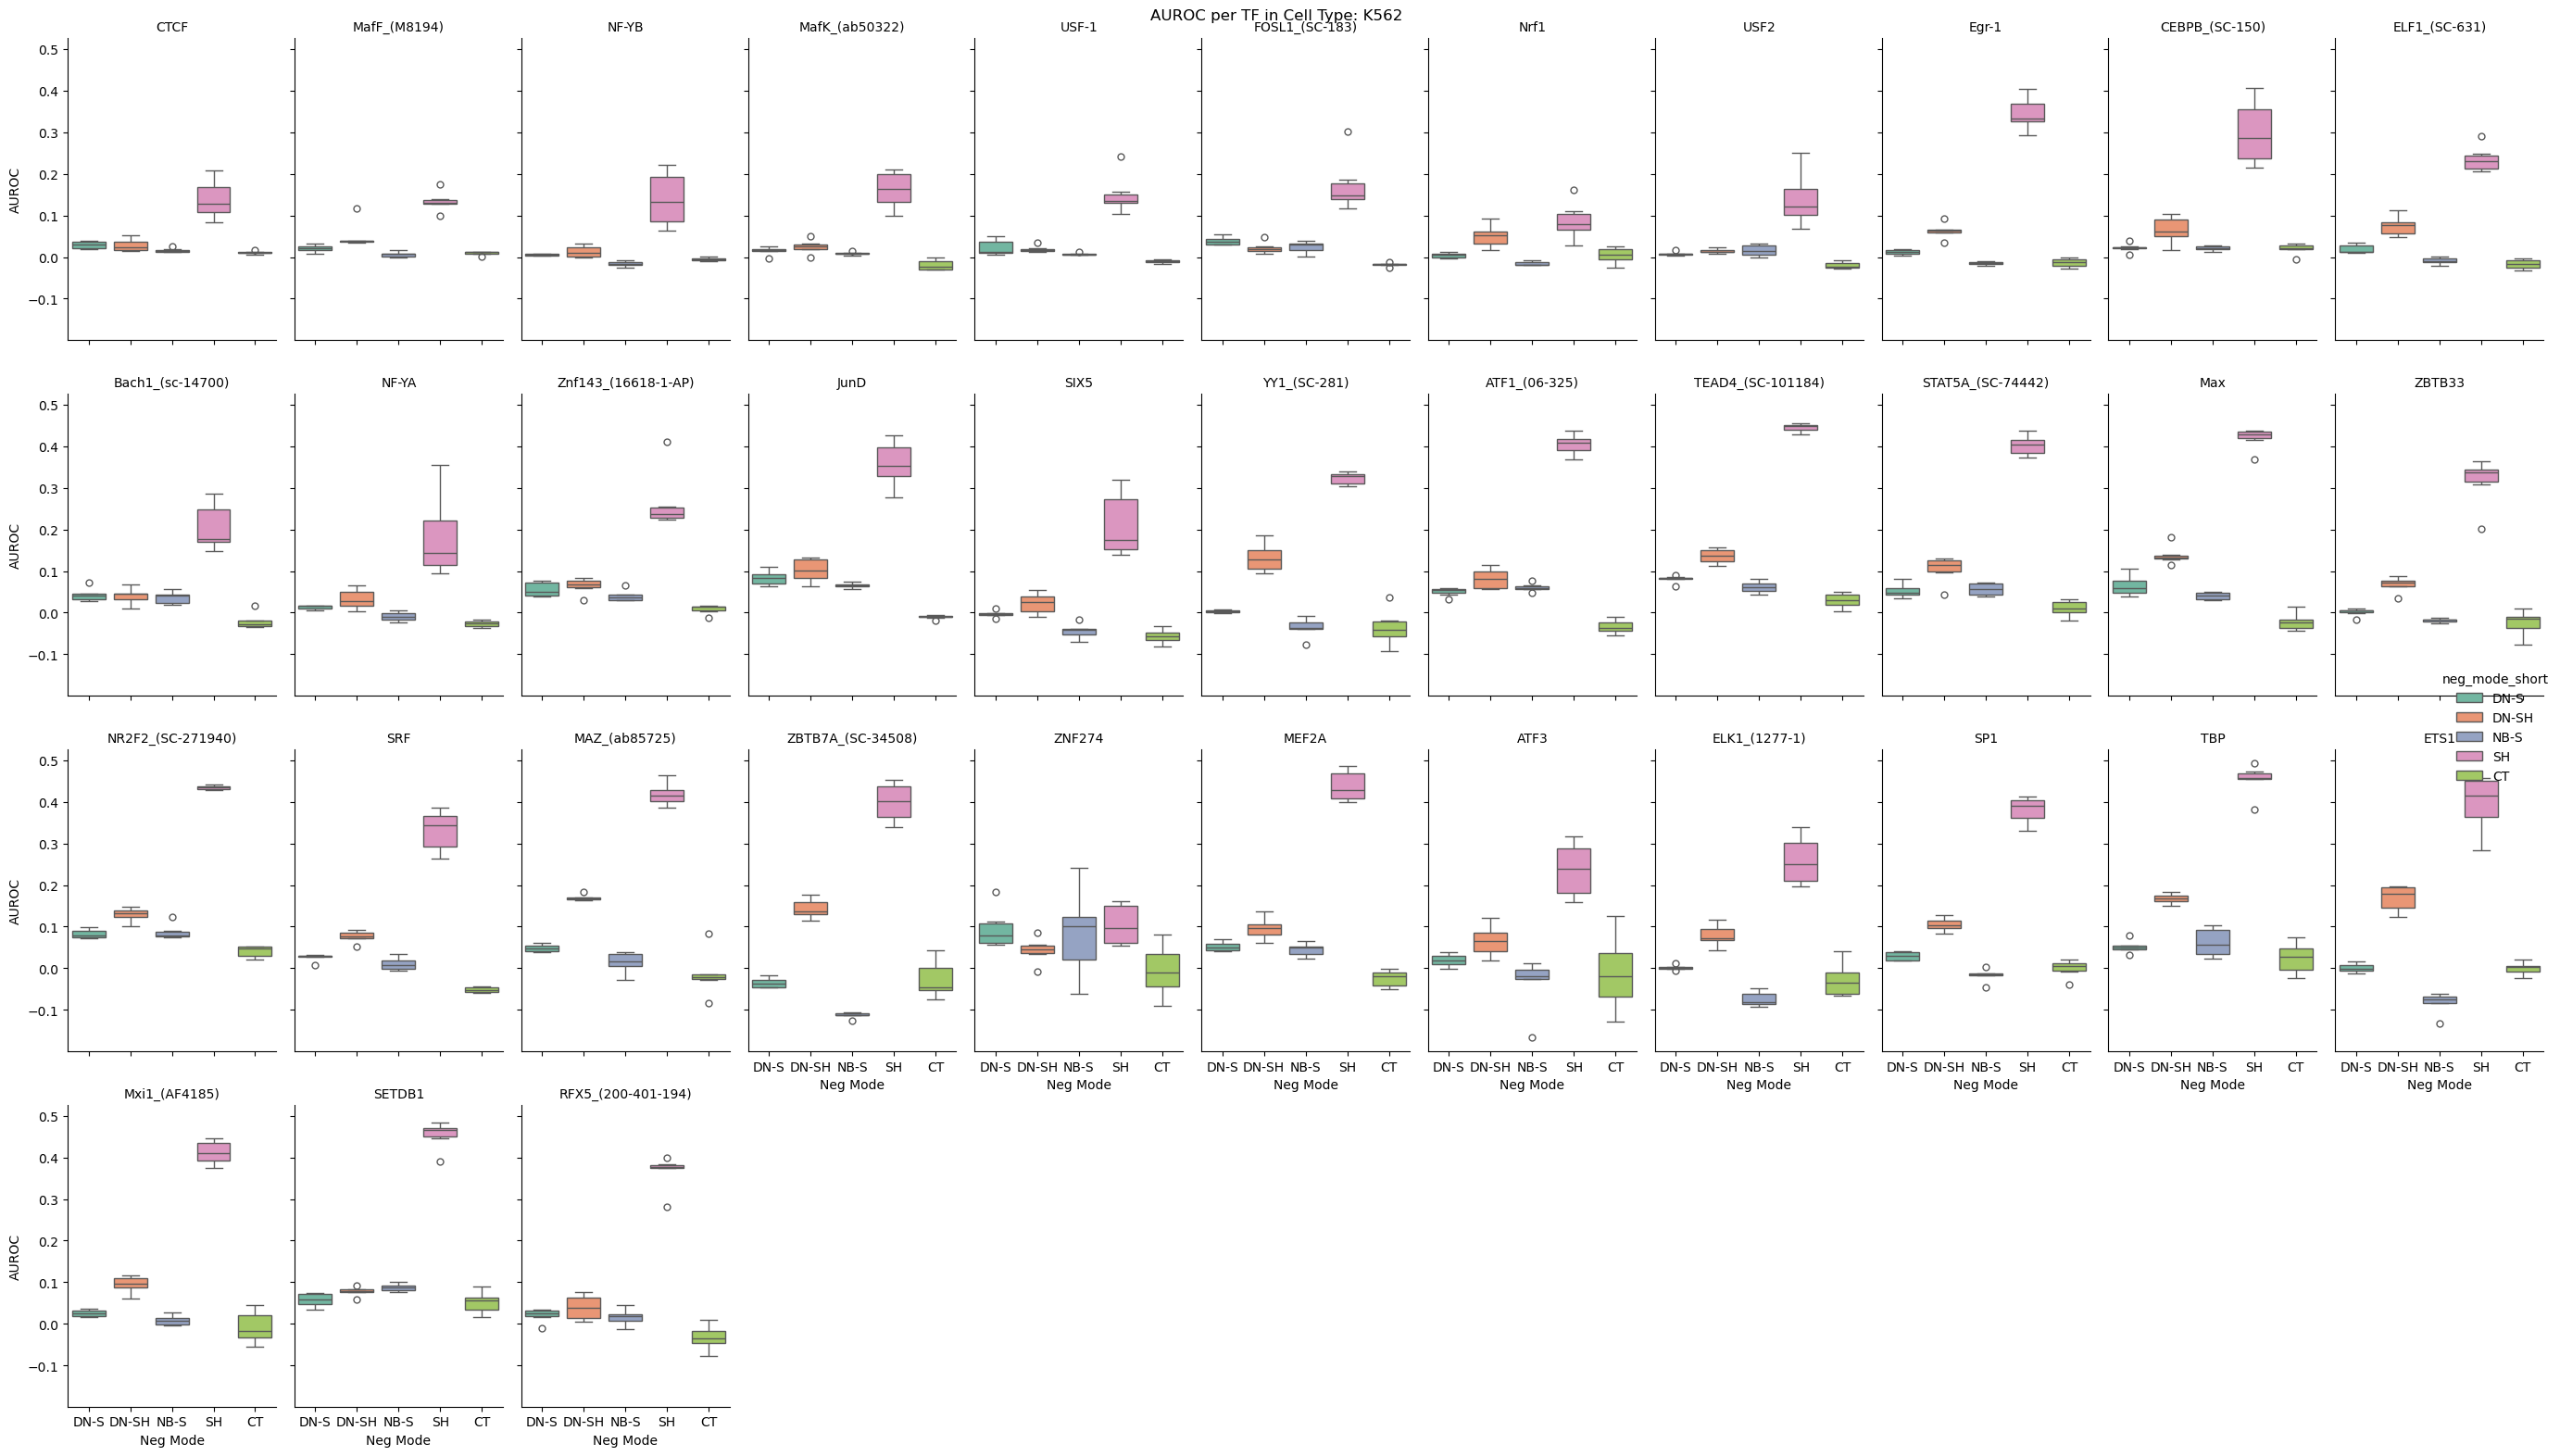

/tmp/ipykernel_4150194/3202167321.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
/tmp/ipykernel_4150194/3202167321.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)


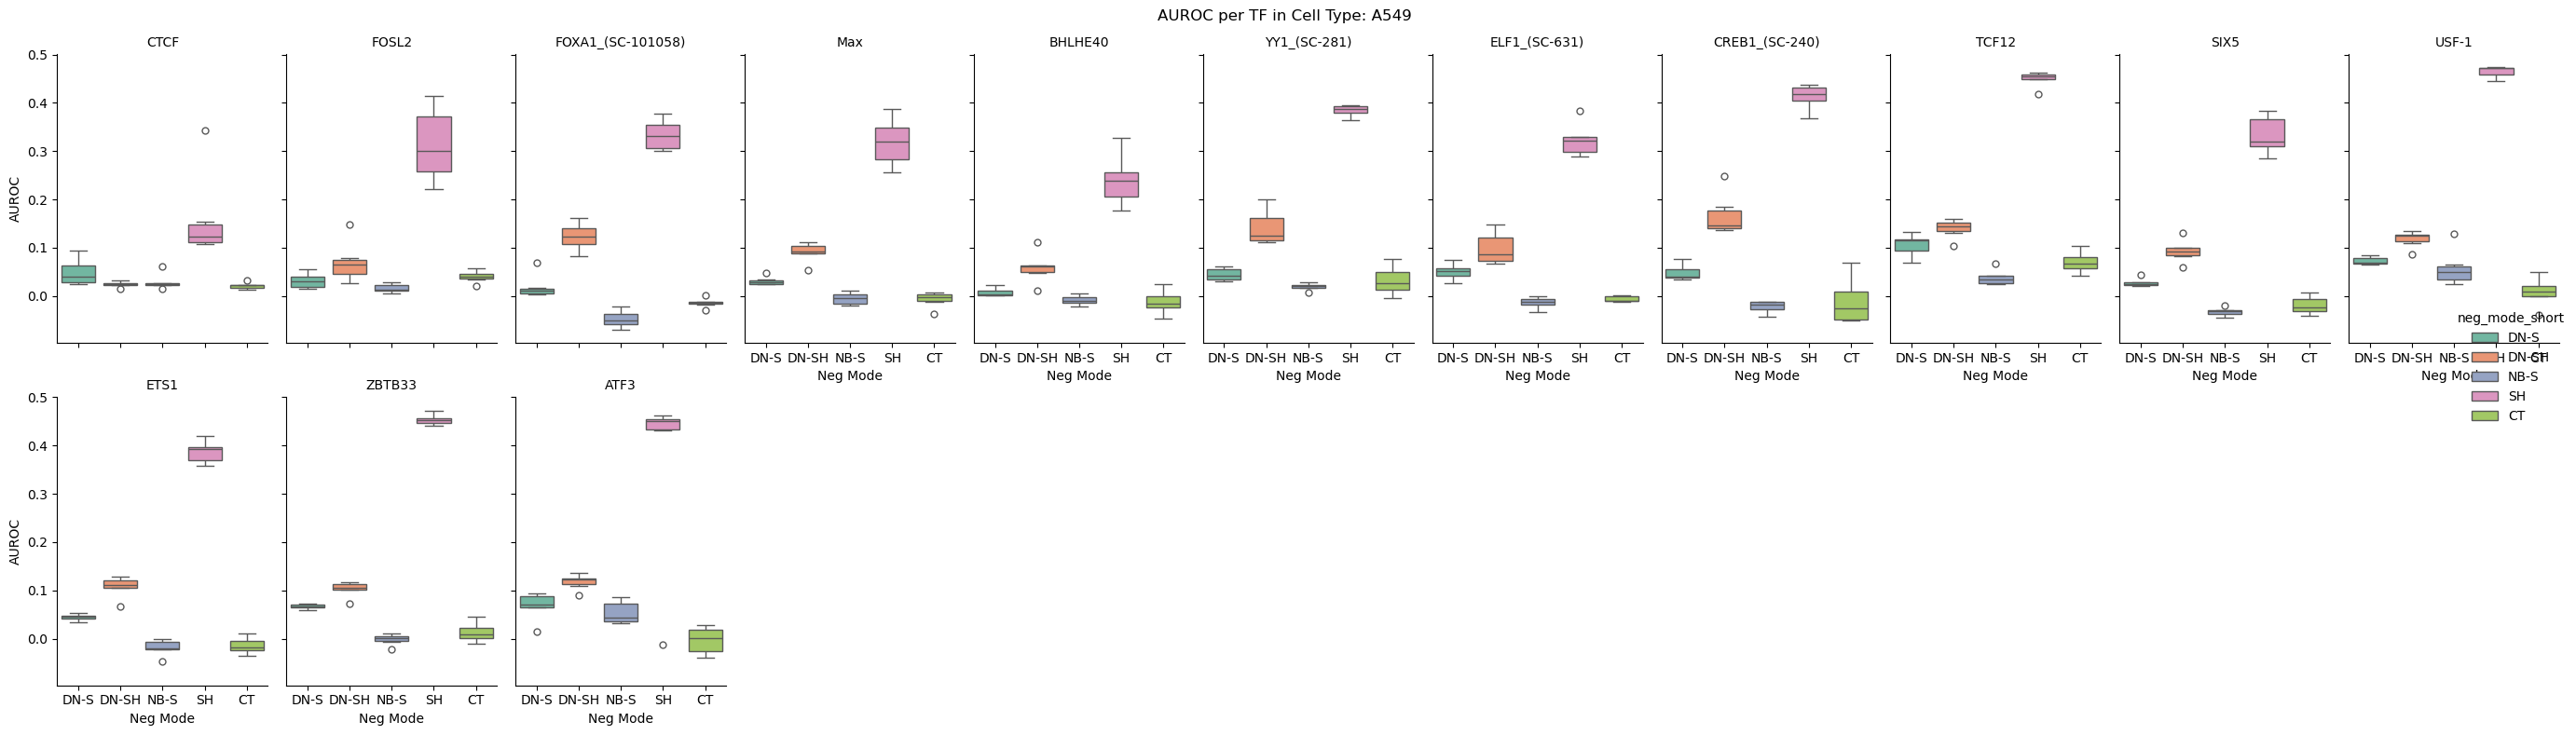

In [23]:
# WRONG FIGURES! STILL NEED TO FIX THEM
import matplotlib.pyplot as plt
import seaborn as sns
unique_celltypes = results_df["celltype"].unique().tolist()
for celltype in unique_celltypes:
    # Filter the DataFrame for the current cell type
    celltype_df = results_df[results_df['celltype'] == celltype]
    mean_auroc_per_tf = celltype_df.groupby('TF')['AUROC'].mean().sort_values(ascending=False)
    tf_order = mean_auroc_per_tf.index.tolist()

    # Create a custom order for neg_sampling types
    neg_sampling_order = ['dinucl_sampled', 'dinucl_shuffled', 'neighbors', 'shuffled', "celltype"]

    # Sort the DataFrame by TF (using the custom order) and neg_sampling type
    celltype_df['TF'] = pd.Categorical(celltype_df['TF'], categories=tf_order, ordered=True)
    celltype_df['neg_mode'] = pd.Categorical(celltype_df['neg_mode'], categories=neg_sampling_order, ordered=True)
    celltype_df = celltype_df.sort_values(['TF', 'neg_mode'])


    # Shorten neg_mode labels
    neg_mode_labels = {
        'dinucl_sampled': 'DN-S',
        'dinucl_shuffled': 'DN-SH',
        'neighbors': 'NB-S',
        'shuffled': 'SH',
        'celltype': 'CT',
        'HQ training': 'HQ'
    }

    # Apply and order short labels
    celltype_df['neg_mode_short'] = celltype_df['neg_mode'].map(neg_mode_labels)
    neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH', 'CT']
    celltype_df['neg_mode_short'] = pd.Categorical(celltype_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

    # Create the catplot
    g = sns.catplot(
        data=celltype_df,
        x='neg_mode_short',
        col='TF',
        y='AUROC_delta',
        hue='neg_mode_short',
        kind='box',
        col_wrap=11,
        height=4,
        aspect=0.6,
        palette='Set2'
    )

    # Titles and labels
    g.set_titles(col_template="{col_name}")
    g.set_axis_labels("Neg Mode", "AUROC")

    # Fix x-tick rotation manually
    # for ax in g.axes.flatten():
    #     for label in ax.get_xticklabels():
    #         label.set_rotation(90)
    #     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
    g.fig.suptitle(f"AUROC per TF in Cell Type: {celltype}")
    plt.tight_layout()
    plt.show()

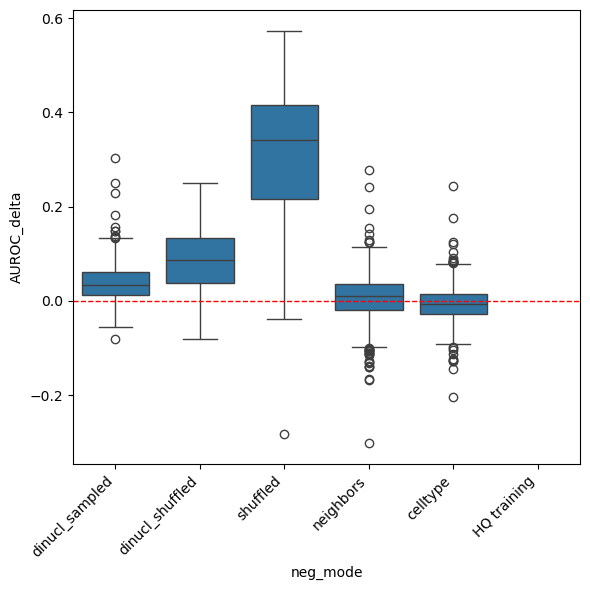

In [24]:
plt.figure(figsize=(6, 6))
# Create the boxplot
sns.boxplot(data=results_df, x='neg_mode', y='AUROC_delta')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

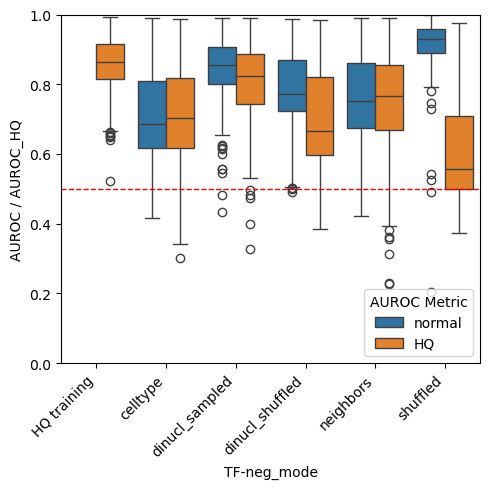

In [25]:
# Create the boxplot for AUROC
plt.figure(figsize=(5, 5))

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    results_df.sort_values(by=['TF-neg_mode']),
    id_vars=['neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})


# Create the boxplot
sns.boxplot(data=melted_df, x='neg_mode', y='AUROC_value', hue='auroc_metric')



# Add a horizontal line at y=0.5
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)

# Adjust legend
plt.legend(title='AUROC Metric', loc='lower right')

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.xlabel('TF-neg_mode')

plt.ylabel('AUROC / AUROC_HQ')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [33]:
import pickle

with open("/data/home/natant/Negatives/TFBS_negatives/testing_ground/20250613_NUMBER_OF_POSITIVES_PER_GROUP.pkl", "rb") as f:
    number_of_positives = pickle.load(f)

In [34]:
number_of_positives

{'MCF-7': {'CTCF': (np.int64(7124), np.int64(5733), np.int64(8144)),
  'TCF7L2': (np.int64(2909), np.int64(2949), np.int64(4439)),
  'ZNF217': (np.int64(2911), np.int64(2775), np.int64(4259)),
  'GATA3_(SC-268)': (np.int64(1853), np.int64(1606), np.int64(2624))},
 'GM12878': {'CTCF': (np.int64(12222), np.int64(12053), np.int64(15832)),
  'YY1_(SC-281)': (np.int64(8978), np.int64(9385), np.int64(12635)),
  'TBP': (np.int64(4052), np.int64(4415), np.int64(6423)),
  'Egr-1': (np.int64(4762), np.int64(4919), np.int64(6643)),
  'Mxi1_(AF4185)': (np.int64(5035), np.int64(5307), np.int64(7405)),
  'SRF': (np.int64(2529), np.int64(2546), np.int64(3471)),
  'MAZ_(ab85725)': (np.int64(5355), np.int64(5885), np.int64(7732)),
  'ELK1_(1277-1)': (np.int64(1654), np.int64(1731), np.int64(2199)),
  'SIX5': (np.int64(1613), np.int64(1357), np.int64(1873)),
  'USF-1': (np.int64(2829), np.int64(2985), np.int64(3965)),
  'SP1': (np.int64(5455), np.int64(5421), np.int64(7372)),
  'RFX5_(200-401-194)': (np

In [35]:
# Convert the nested dictionary 'number_of_positives' into a pandas DataFrame
number_of_positives_df = (
    pd.DataFrame([
        {"celltype": ct, "TF": tf, "positives 1": vals[0], "positives 2": vals[1], "positives 3": vals[2]}
        for ct, tf_dict in number_of_positives.items()
        for tf, vals in tf_dict.items()
    ])
)
number_of_positives_df

,celltype,TF,positives 1,positives 2,positives 3
0,MCF-7,CTCF,7124,5733,8144
1,MCF-7,TCF7L2,2909,2949,4439
2,MCF-7,ZNF217,2911,2775,4259
3,MCF-7,GATA3_(SC-268),1853,1606,2624
4,GM12878,CTCF,12222,12053,15832
...,...,...,...,...,...
127,A549,USF-1,2170,2457,3821
128,A549,ETS1,1535,1503,2503
129,A549,SIX5,1488,1318,2109
130,A549,ZBTB33,1896,2039,3222


In [36]:
from itertools import permutations
all_orderings = list(permutations(["part1", "part2", "part3"]))

In [37]:
all_orderings

[('part1', 'part2', 'part3'),
 ('part1', 'part3', 'part2'),
 ('part2', 'part1', 'part3'),
 ('part2', 'part3', 'part1'),
 ('part3', 'part1', 'part2'),
 ('part3', 'part2', 'part1')]

In [38]:
ordering_dict = {i: ordering[0] for i, ordering in enumerate(all_orderings)}

In [39]:
ordering_dict

{0: 'part1', 1: 'part1', 2: 'part2', 3: 'part2', 4: 'part3', 5: 'part3'}

In [40]:
# Map cross_val_set to the corresponding positives column using two dictionaries
crossval_to_part = ordering_dict  # e.g., {0: 'part1', 1: 'part1', 2: 'part2', ...}
part_to_col = {"part1": "positives 1", "part2": "positives 2", "part3": "positives 3"}

def lookup_num_training_positives(row):
    part = crossval_to_part[int(row['cross_val_set'])]
    part_col = part_to_col.get(part)
    match = number_of_positives_df[
        (number_of_positives_df['celltype'] == row['celltype']) &
        (number_of_positives_df['TF'] == row['TF'])
    ]
    if not match.empty and part_col is not None:
        return match.iloc[0][part_col]
    else:
        return np.nan

results_df["num_training_positives"] = results_df.apply(lookup_num_training_positives, axis=1)


In [41]:
results_df

,run_name,TF,celltype,neg_mode,cross_val_set,group_name,AUROC,AUROC_HQ,val_loss,celltype_TF,TF-neg_mode,TF-neg_mode-celltype,AUROC_delta,num_training_positives
96,clear-shape-5260,CTCF,GM12878,dinucl_sampled,0.0,full_run_2,0.969141,0.952979,0.426934,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.016162,12222
97,driven-rain-5261,CTCF,GM12878,dinucl_sampled,1.0,full_run_2,0.961291,0.925307,0.522846,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.035984,12222
98,dandy-serenity-5262,CTCF,GM12878,dinucl_sampled,2.0,full_run_2,0.975019,0.960630,0.426776,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.014388,12053
99,good-thunder-5263,CTCF,GM12878,dinucl_sampled,3.0,full_run_2,0.968358,0.928841,0.440390,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.039517,12053
100,whole-pond-5264,CTCF,GM12878,dinucl_sampled,4.0,full_run_2,0.980562,0.963547,0.215077,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.017015,15832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4459,A549_FOXA1_(SC-101058)_CV1_20250619_02:36,FOXA1_(SC-101058),A549,HQ training,1.0,full_run_3_HQ,NaN,0.907562,0.457816,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549,NaN,2180
4460,A549_FOXA1_(SC-101058)_CV2_20250619_02:36,FOXA1_(SC-101058),A549,HQ training,2.0,full_run_3_HQ,NaN,0.902594,0.542374,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549,NaN,2119
4461,A549_FOXA1_(SC-101058)_CV3_20250619_02:36,FOXA1_(SC-101058),A549,HQ training,3.0,full_run_3_HQ,NaN,0.912508,0.418853,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549,NaN,2119
4462,A549_FOXA1_(SC-101058)_CV4_20250619_02:37,FOXA1_(SC-101058),A549,HQ training,4.0,full_run_3_HQ,NaN,0.912237,0.496110,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549,NaN,3401


In [42]:
results_df["num_training_positives"]

96      12222
97      12222
98      12053
99      12053
100     15832
        ...  
4459     2180
4460     2119
4461     2119
4462     3401
4463     3401
Name: num_training_positives, Length: 4284, dtype: int64

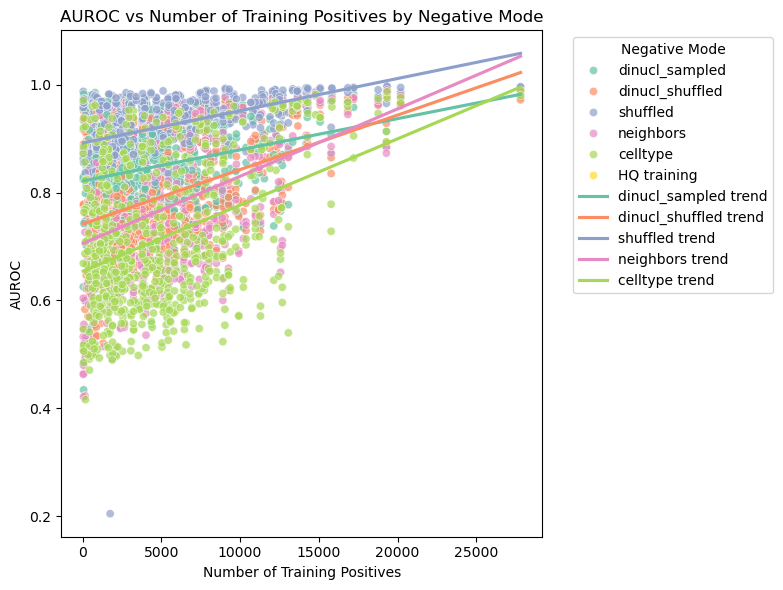

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=results_df,
    x="num_training_positives",
    y="AUROC",
    hue="neg_mode",
    palette="Set2",
    alpha=0.7
)

# Add trend lines for each neg_mode
for neg_mode, color in zip(results_df["neg_mode"].unique(), sns.color_palette("Set2")):
    subset = results_df[results_df["neg_mode"] == neg_mode]
    sns.regplot(
        data=subset,
        x="num_training_positives",
        y="AUROC",
        scatter=False,
        color=color,
        label=f"{neg_mode} trend",
        ci=None
    )

plt.xlabel("Number of Training Positives")
plt.ylabel("AUROC")
plt.title("AUROC vs Number of Training Positives by Negative Mode")
plt.legend(title="Negative Mode", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

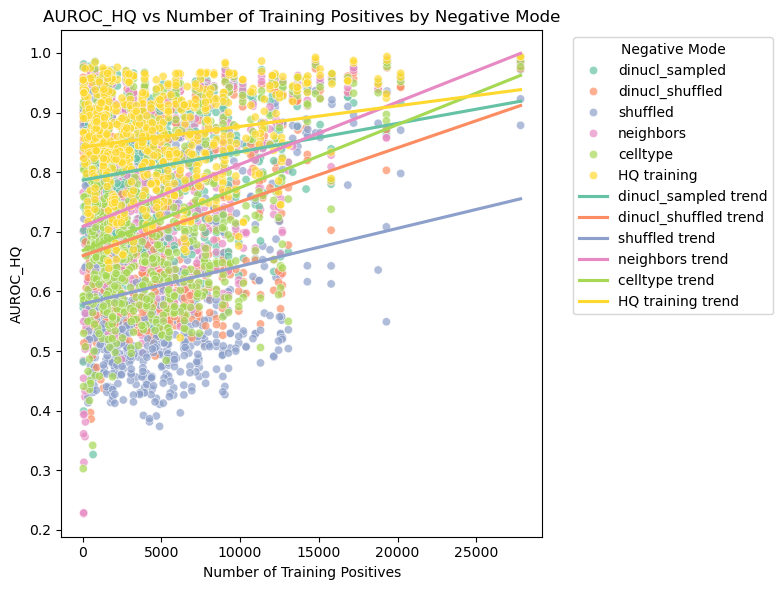

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=results_df,
    x="num_training_positives",
    y="AUROC_HQ",
    hue="neg_mode",
    palette="Set2",
    alpha=0.7
)

# Add trend lines for each neg_mode
for neg_mode, color in zip(results_df["neg_mode"].unique(), sns.color_palette("Set2")):
    subset = results_df[results_df["neg_mode"] == neg_mode]
    sns.regplot(
        data=subset,
        x="num_training_positives",
        y="AUROC_HQ",
        scatter=False,
        color=color,
        label=f"{neg_mode} trend",
        ci=None
    )

plt.xlabel("Number of Training Positives")
plt.ylabel("AUROC_HQ")
plt.title("AUROC_HQ vs Number of Training Positives by Negative Mode")
plt.legend(title="Negative Mode", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

UNDER HERE IS CHATGPT CODE, DUBBEL CHECK THAT IT IS CORRECT!!

In [45]:
results_df

,run_name,TF,celltype,neg_mode,cross_val_set,group_name,AUROC,AUROC_HQ,val_loss,celltype_TF,TF-neg_mode,TF-neg_mode-celltype,AUROC_delta,num_training_positives
96,clear-shape-5260,CTCF,GM12878,dinucl_sampled,0.0,full_run_2,0.969141,0.952979,0.426934,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.016162,12222
97,driven-rain-5261,CTCF,GM12878,dinucl_sampled,1.0,full_run_2,0.961291,0.925307,0.522846,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.035984,12222
98,dandy-serenity-5262,CTCF,GM12878,dinucl_sampled,2.0,full_run_2,0.975019,0.960630,0.426776,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.014388,12053
99,good-thunder-5263,CTCF,GM12878,dinucl_sampled,3.0,full_run_2,0.968358,0.928841,0.440390,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.039517,12053
100,whole-pond-5264,CTCF,GM12878,dinucl_sampled,4.0,full_run_2,0.980562,0.963547,0.215077,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.017015,15832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4459,A549_FOXA1_(SC-101058)_CV1_20250619_02:36,FOXA1_(SC-101058),A549,HQ training,1.0,full_run_3_HQ,NaN,0.907562,0.457816,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549,NaN,2180
4460,A549_FOXA1_(SC-101058)_CV2_20250619_02:36,FOXA1_(SC-101058),A549,HQ training,2.0,full_run_3_HQ,NaN,0.902594,0.542374,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549,NaN,2119
4461,A549_FOXA1_(SC-101058)_CV3_20250619_02:36,FOXA1_(SC-101058),A549,HQ training,3.0,full_run_3_HQ,NaN,0.912508,0.418853,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549,NaN,2119
4462,A549_FOXA1_(SC-101058)_CV4_20250619_02:37,FOXA1_(SC-101058),A549,HQ training,4.0,full_run_3_HQ,NaN,0.912237,0.496110,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549,NaN,3401


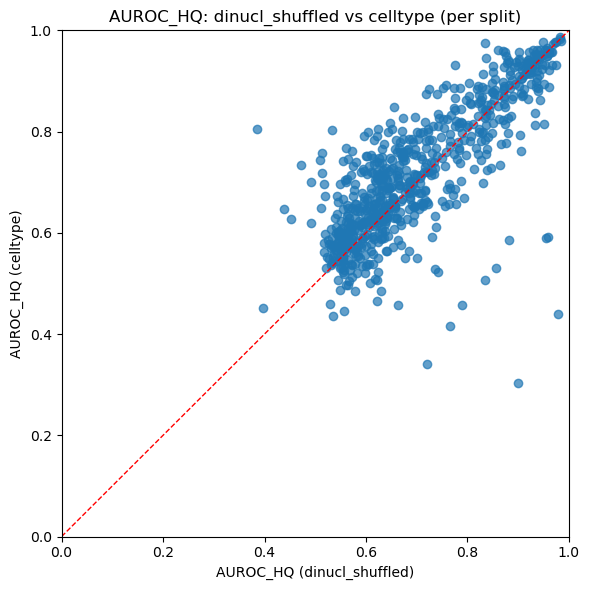

In [46]:
import matplotlib.pyplot as plt

# Merge on TF, celltype, and cross_val_set to align the two modes using results_df
merged = pd.merge(
    results_df[results_df['neg_mode'] == 'dinucl_shuffled'][['TF', 'celltype', 'cross_val_set', 'AUROC_HQ']],
    results_df[results_df['neg_mode'] == 'celltype'][['TF', 'celltype', 'cross_val_set', 'AUROC_HQ']],
    on=['TF', 'celltype', 'cross_val_set'],
    suffixes=('_dinucl_shuffled', '_celltype')
)

plt.figure(figsize=(6, 6))
plt.scatter(
    merged['AUROC_HQ_dinucl_shuffled'],
    merged['AUROC_HQ_celltype'],
    alpha=0.7
)
plt.plot([0, 1], [0, 1], 'r--', linewidth=1)
plt.xlabel('AUROC_HQ (dinucl_shuffled)')
plt.ylabel('AUROC_HQ (celltype)')
plt.title('AUROC_HQ: dinucl_shuffled vs celltype (per split)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Now do this comparison between all the type of negatives

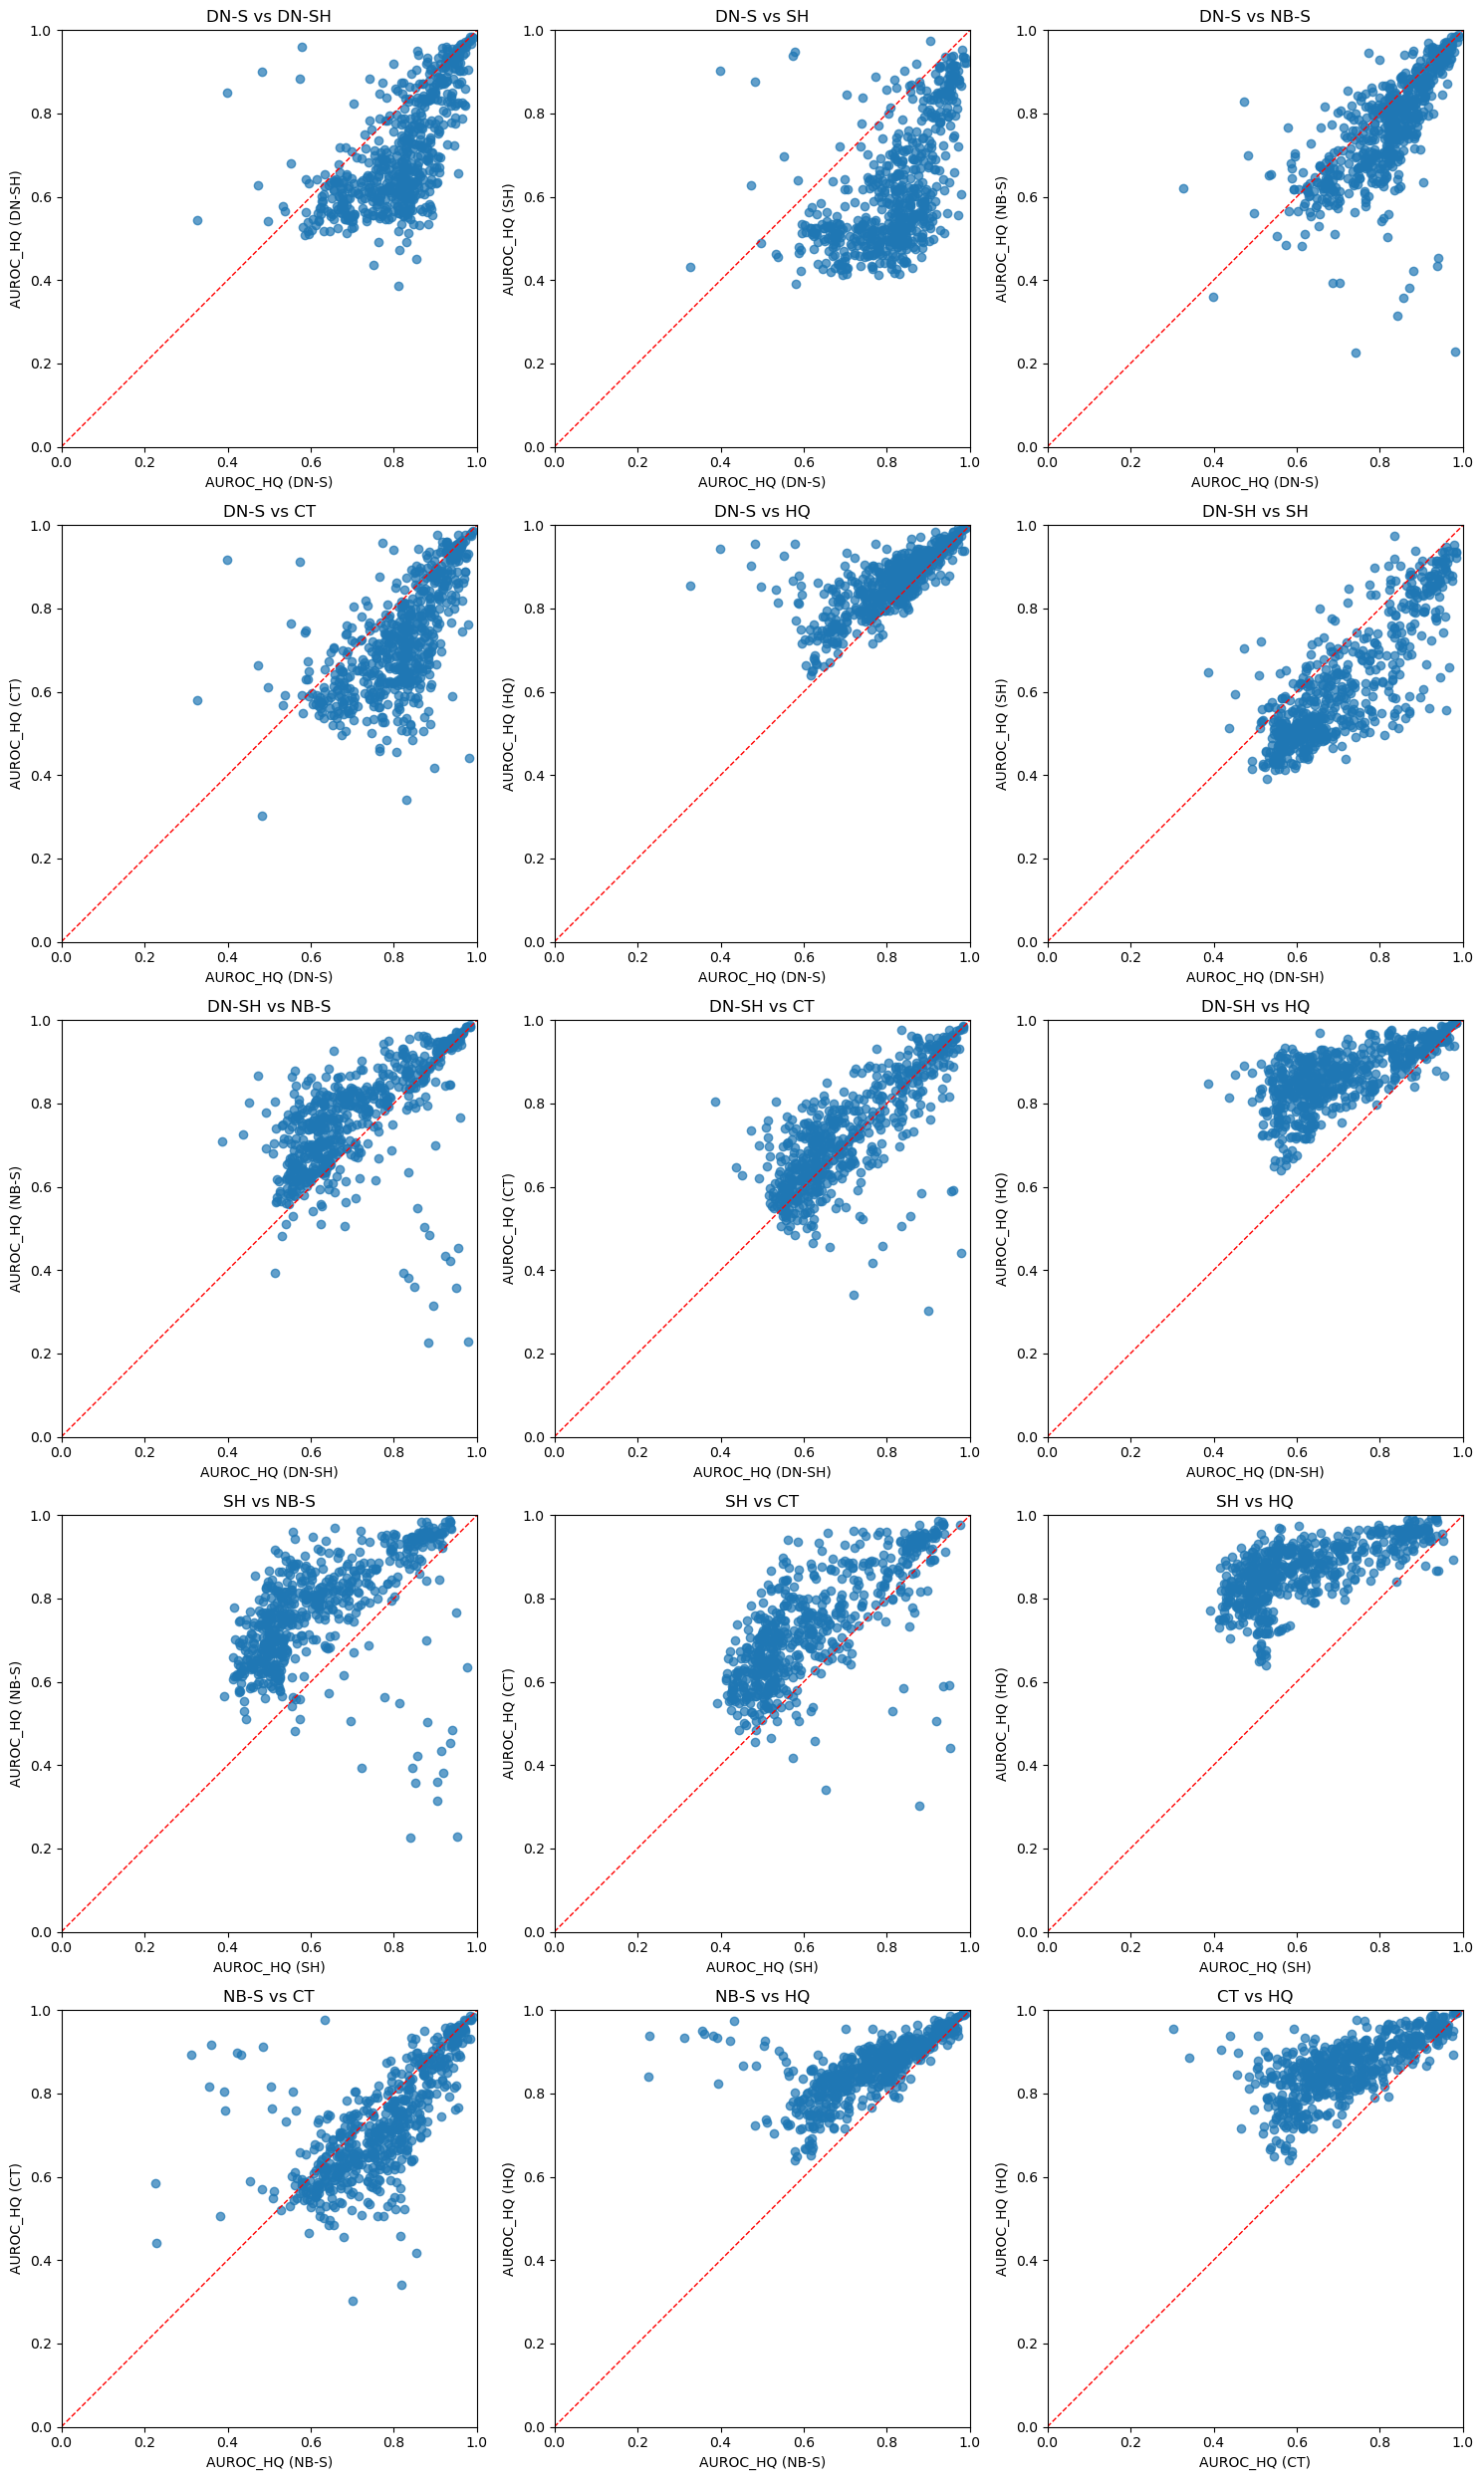

In [47]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

# Only use celltypes and TFs present in motif_df for fair comparison
celltypes = motif_celltypes
tfs = motif_df["TF"].unique()

# All negative modes to compare (excluding motif)
all_modes = ['dinucl_sampled', 'dinucl_shuffled', 'shuffled', 'neighbors', 'celltype', 'HQ training']
mode_labels = neg_mode_labels

# Prepare a DataFrame with all relevant data from results_df, including cross_val_set
results_part = results_df[
    (results_df['celltype'].isin(celltypes)) &
    (results_df['TF'].isin(tfs)) &
    (results_df['neg_mode'].isin(all_modes))
][['TF', 'celltype', 'neg_mode', 'cross_val_set', 'AUROC_HQ']]

plot_df = results_part.copy()

# Prepare all pairs of negative modes (without duplicates, order doesn't matter)
mode_pairs = list(itertools.combinations(all_modes, 2))

ncols = 3
nrows = int(np.ceil(len(mode_pairs) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5), squeeze=False)

for idx, (mode1, mode2) in enumerate(mode_pairs):
    ax = axes[idx // ncols, idx % ncols]
    df1 = plot_df[plot_df['neg_mode'] == mode1][['TF', 'celltype', 'cross_val_set', 'AUROC_HQ']]
    df2 = plot_df[plot_df['neg_mode'] == mode2][['TF', 'celltype', 'cross_val_set', 'AUROC_HQ']]
    merged = pd.merge(
        df1, df2,
        on=['TF', 'celltype', 'cross_val_set'],
        suffixes=(f'_{mode1}', f'_{mode2}')
    )
    ax.scatter(
        merged[f'AUROC_HQ_{mode1}'],
        merged[f'AUROC_HQ_{mode2}'],
        alpha=0.7
    )
    ax.plot([0, 1], [0, 1], 'r--', linewidth=1)
    ax.set_xlabel(f"AUROC_HQ ({mode_labels.get(mode1, mode1)})")
    ax.set_ylabel(f"AUROC_HQ ({mode_labels.get(mode2, mode2)})")
    ax.set_title(f"{mode_labels.get(mode1, mode1)} vs {mode_labels.get(mode2, mode2)}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# Remove empty subplots
for i in range(len(mode_pairs), nrows * ncols):
    fig.delaxes(axes[i // ncols, i % ncols])

plt.tight_layout()
plt.show()


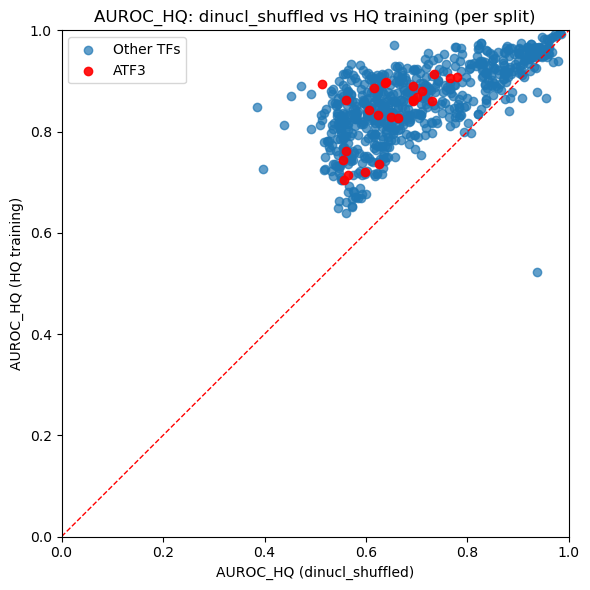

In [48]:
import matplotlib.pyplot as plt

# Merge on TF, celltype, and cross_val_set to align the two modes using results_df
merged = pd.merge(
    results_df[results_df['neg_mode'] == 'dinucl_shuffled'][['TF', 'celltype', 'cross_val_set', 'AUROC_HQ']],
    results_df[results_df['neg_mode'] == 'HQ training'][['TF', 'celltype', 'cross_val_set', 'AUROC_HQ']],
    on=['TF', 'celltype', 'cross_val_set'],
    suffixes=('_dinucl_shuffled', '_HQ_training')
)

# Identify points for ATF3
is_atf3 = merged['TF'] == 'ATF3'

plt.figure(figsize=(6, 6))
# Plot all points except ATF3 in default color
plt.scatter(
    merged.loc[~is_atf3, 'AUROC_HQ_dinucl_shuffled'],
    merged.loc[~is_atf3, 'AUROC_HQ_HQ_training'],
    alpha=0.7,
    label='Other TFs'
)
# Plot ATF3 points in red
plt.scatter(
    merged.loc[is_atf3, 'AUROC_HQ_dinucl_shuffled'],
    merged.loc[is_atf3, 'AUROC_HQ_HQ_training'],
    color='red',
    alpha=0.9,
    label='ATF3'
)
plt.plot([0, 1], [0, 1], 'r--', linewidth=1)
plt.xlabel('AUROC_HQ (dinucl_shuffled)')
plt.ylabel('AUROC_HQ (HQ training)')
plt.title('AUROC_HQ: dinucl_shuffled vs HQ training (per split)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_4150194/3525004633.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


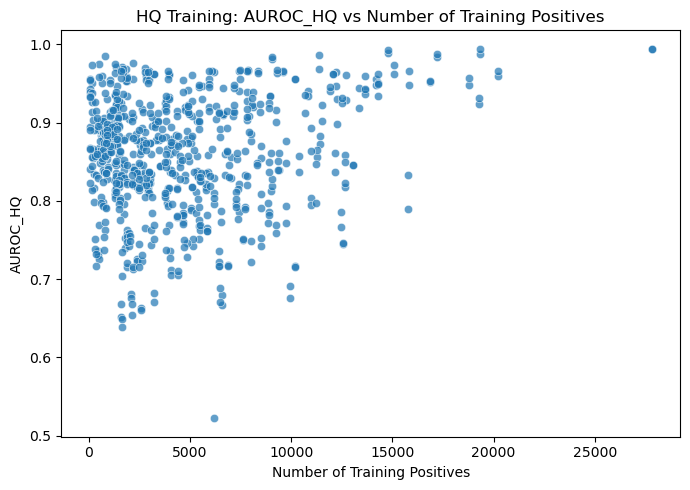

In [49]:
import seaborn as sns

import matplotlib.pyplot as plt

# Filter for HQ training subset in results_df
hq_training_df = results_df[results_df["neg_mode"] == "HQ training"]

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=hq_training_df,
    x="num_training_positives",
    y="AUROC_HQ",
    #hue="TF",
    alpha=0.7,
    palette="Set2"
)


plt.xlabel("Number of Training Positives")
plt.ylabel("AUROC_HQ")
plt.title("HQ Training: AUROC_HQ vs Number of Training Positives")
#plt.legend(title="Celltype", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [50]:
results_df[
    (results_df['celltype'].isin(celltypes)) &
    (results_df['neg_mode'].isin(["HQ training"])) &
     (results_df['AUROC_HQ'] < 0.6) &
     (results_df['TF'] == "ATF3")]

,run_name,TF,celltype,neg_mode,cross_val_set,group_name,AUROC,AUROC_HQ,val_loss,celltype_TF,TF-neg_mode,TF-neg_mode-celltype,AUROC_delta,num_training_positives


In [51]:
results_df[
    (results_df['celltype'].isin(celltypes)) &
    (results_df['neg_mode'].isin(["HQ training"])) &
     (results_df['AUROC_HQ'] < 0.6)]["TF"].value_counts()

TF
USF-1    1
Name: count, dtype: int64

In [52]:
results_df[
    (results_df['celltype'].isin(celltypes)) &
    (results_df['neg_mode'].isin(["HQ training"])) &
     (results_df['AUROC_HQ'] < 0.6)]

,run_name,TF,celltype,neg_mode,cross_val_set,group_name,AUROC,AUROC_HQ,val_loss,celltype_TF,TF-neg_mode,TF-neg_mode-celltype,AUROC_delta,num_training_positives
3966,HepG2_USF-1_CV0_20250618_18:15,USF-1,HepG2,HQ training,0.0,full_run_3_HQ,NaN,0.522211,0.710401,HepG2_USF-1,USF-1_HQ training,USF-1_HQ training_HepG2,NaN,6194


/tmp/ipykernel_4150194/1616947679.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_4150194/1616947679.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


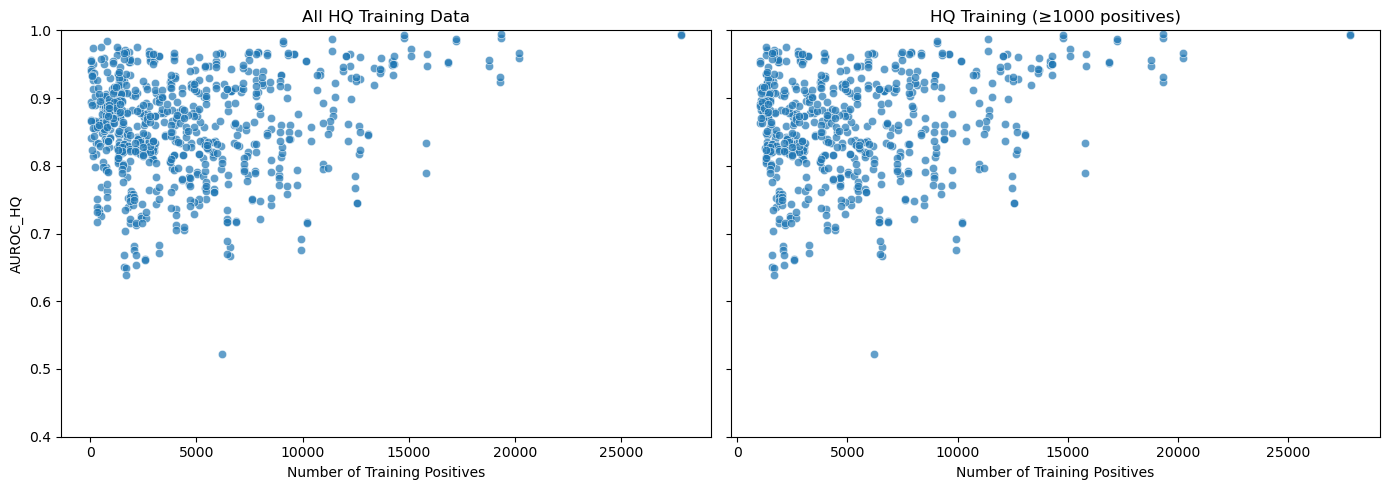

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for HQ training subset in results_df
hq_training_df = results_df[results_df["neg_mode"] == "HQ training"]
hq_training_df_1000 = hq_training_df[hq_training_df["num_training_positives"] >= 1000]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Left: all data
sns.scatterplot(
    data=hq_training_df,
    x="num_training_positives",
    y="AUROC_HQ",
    alpha=0.7,
    palette="Set2",
    ax=axes[0]
)
axes[0].set_title("All HQ Training Data")
axes[0].set_xlabel("Number of Training Positives")
axes[0].set_ylabel("AUROC_HQ")
axes[0].set_ylim(0.4, 1)

# Right: only >=1000 positives
sns.scatterplot(
    data=hq_training_df_1000,
    x="num_training_positives",
    y="AUROC_HQ",
    alpha=0.7,
    palette="Set2",
    ax=axes[1]
)
axes[1].set_title("HQ Training (≥1000 positives)")
axes[1].set_xlabel("Number of Training Positives")
axes[1].set_ylabel("")
axes[1].set_ylim(0.4, 1)

plt.tight_layout()
plt.show()


<Axes: ylabel='Frequency'>

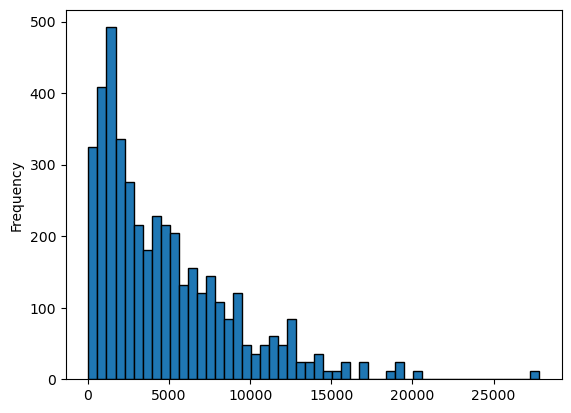

In [54]:
results_df['num_training_positives'].plot(kind='hist', bins=50, edgecolor='black')

In [55]:
# Group by TF, celltype, and neg_mode, then average AUROC and AUROC_HQ
grouped_avg = results_df.groupby(['TF', 'celltype', 'neg_mode'], as_index=False)[['AUROC', 'AUROC_HQ', 'num_training_positives']].mean()
grouped_avg

,TF,celltype,neg_mode,AUROC,AUROC_HQ,num_training_positives
0,ARID3A_(NB100-279),HepG2,HQ training,NaN,0.858777,5873.666667
1,ARID3A_(NB100-279),HepG2,celltype,0.641804,0.599579,5873.666667
2,ARID3A_(NB100-279),HepG2,dinucl_sampled,0.766061,0.702276,5873.666667
3,ARID3A_(NB100-279),HepG2,dinucl_shuffled,0.706626,0.569683,5873.666667
4,ARID3A_(NB100-279),HepG2,neighbors,0.718460,0.682193,5873.666667
...,...,...,...,...,...,...
709,Znf143_(16618-1-AP),K562,celltype,0.782408,0.774070,9686.666667
710,Znf143_(16618-1-AP),K562,dinucl_sampled,0.891440,0.835624,9686.666667
711,Znf143_(16618-1-AP),K562,dinucl_shuffled,0.873682,0.809226,9686.666667
712,Znf143_(16618-1-AP),K562,neighbors,0.844760,0.804817,9686.666667


In [56]:
results_df.groupby(['TF', 'celltype', 'neg_mode'], as_index=False)['num_training_positives'].max()

,TF,celltype,neg_mode,num_training_positives
0,ARID3A_(NB100-279),HepG2,HQ training,8498
1,ARID3A_(NB100-279),HepG2,celltype,8498
2,ARID3A_(NB100-279),HepG2,dinucl_sampled,8498
3,ARID3A_(NB100-279),HepG2,dinucl_shuffled,8498
4,ARID3A_(NB100-279),HepG2,neighbors,8498
...,...,...,...,...
709,Znf143_(16618-1-AP),K562,celltype,10963
710,Znf143_(16618-1-AP),K562,dinucl_sampled,10963
711,Znf143_(16618-1-AP),K562,dinucl_shuffled,10963
712,Znf143_(16618-1-AP),K562,neighbors,10963


In [67]:
grouped_avg["TF-neg_mode"] = grouped_avg["TF"] + "-" + grouped_avg["neg_mode"]

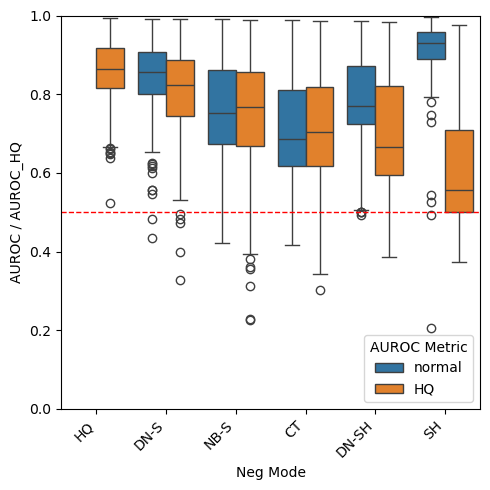

In [58]:
# Map neg_mode to short labels
melted_df['neg_mode_short'] = melted_df['neg_mode'].map(neg_mode_labels)

# Compute mean AUROC_HQ per neg_mode_short and sort
mean_per_mode = (
    grouped_avg
    .assign(neg_mode_short=grouped_avg['neg_mode'].map(neg_mode_labels))
    .groupby('neg_mode_short')['AUROC_HQ']
    .mean()
    .sort_values(ascending=False)
)
neg_mode_order = mean_per_mode.index.tolist()

# Set categorical order for plotting
melted_df['neg_mode_short'] = pd.Categorical(melted_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

plt.figure(figsize=(5, 5))
sns.boxplot(data=melted_df, x='neg_mode_short', y='AUROC_value', hue='auroc_metric')
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
plt.legend(title='AUROC Metric', loc='lower right')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Neg Mode')
plt.ylabel('AUROC / AUROC_HQ')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


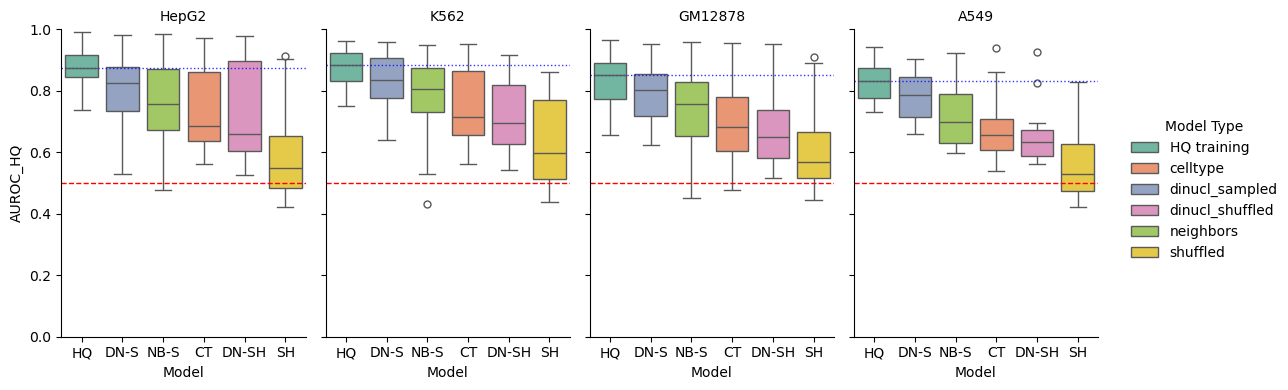

In [59]:
# Compute global mean AUROC_HQ per neg_mode_short
grouped_avg["neg_mode_short"] = grouped_avg['neg_mode'].map(neg_mode_labels)
mean_per_mode = grouped_avg.groupby("neg_mode_short")["AUROC_HQ"].mean().sort_values(ascending=False)
neg_mode_order = mean_per_mode.index.tolist()

# Set categorical order for plotting
grouped_avg["neg_mode_short"] = pd.Categorical(grouped_avg["neg_mode_short"], categories=neg_mode_order, ordered=True)

# Compute mean AUROC_HQ for HQ training per celltype
hq_means = grouped_avg[grouped_avg["neg_mode_short"] == "HQ"].groupby("celltype")["AUROC_HQ"].median().to_dict()

g = sns.catplot(
    data=grouped_avg,
    x='neg_mode_short',
    col='celltype',
    y='AUROC_HQ',
    hue='neg_mode',
    kind='box',
    height=4,
    aspect=0.6,
    palette='Set2'
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Model", "AUROC_HQ")
g._legend.set_bbox_to_anchor((1, 0.5))
g._legend.set_loc("center left")
g._legend.set_title("Model Type")
g.set(ylim=(0, 1))
for ax, celltype in zip(g.axes.flatten(), g.col_names):
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
    if celltype in hq_means:
        ax.axhline(hq_means[celltype], linestyle=':', color='blue', linewidth=1, alpha=0.8,label='HQ mean')
plt.tight_layout()
plt.show()


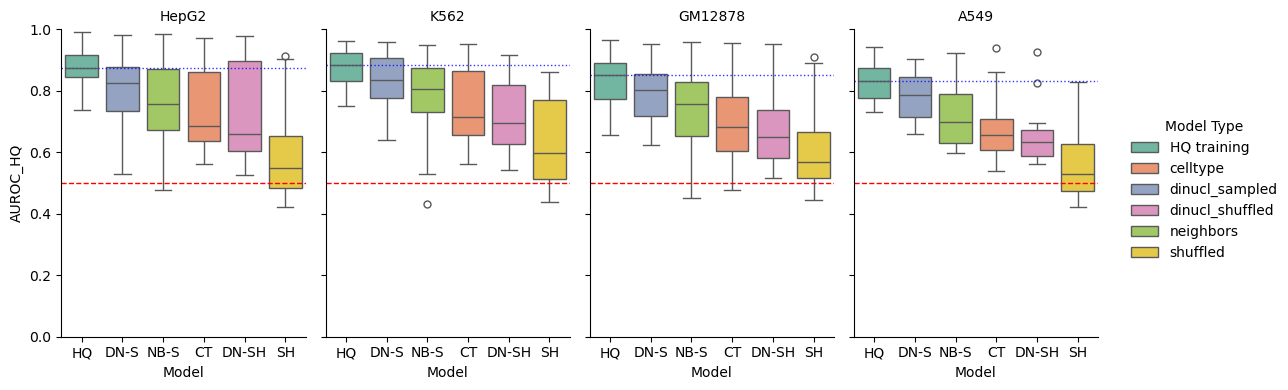

In [60]:
# Compute global mean AUROC_HQ per neg_mode_short
grouped_avg["neg_mode_short"] = grouped_avg['neg_mode'].map(neg_mode_labels)
mean_per_mode = grouped_avg.groupby("neg_mode_short")["AUROC_HQ"].mean().sort_values(ascending=False)
neg_mode_order = mean_per_mode.index.tolist()

# Set categorical order for plotting
grouped_avg["neg_mode_short"] = pd.Categorical(grouped_avg["neg_mode_short"], categories=neg_mode_order, ordered=True)

# Compute mean AUROC_HQ for HQ training per celltype
hq_means = grouped_avg[grouped_avg["neg_mode_short"] == "HQ"].groupby("celltype")["AUROC_HQ"].median().to_dict()

g = sns.catplot(
    data=grouped_avg,
    x='neg_mode_short',
    col='celltype',
    y='AUROC_HQ',
    hue='neg_mode',
    kind='box',
    height=4,
    aspect=0.6,
    palette='Set2'
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Model", "AUROC_HQ")
g._legend.set_bbox_to_anchor((1, 0.5))
g._legend.set_loc("center left")
g._legend.set_title("Model Type")
g.set(ylim=(0, 1))
for ax, celltype in zip(g.axes.flatten(), g.col_names):
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
    if celltype in hq_means:
        ax.axhline(hq_means[celltype], linestyle=':', color='blue', linewidth=1, alpha=0.8,label='HQ mean')
plt.tight_layout()
plt.show()


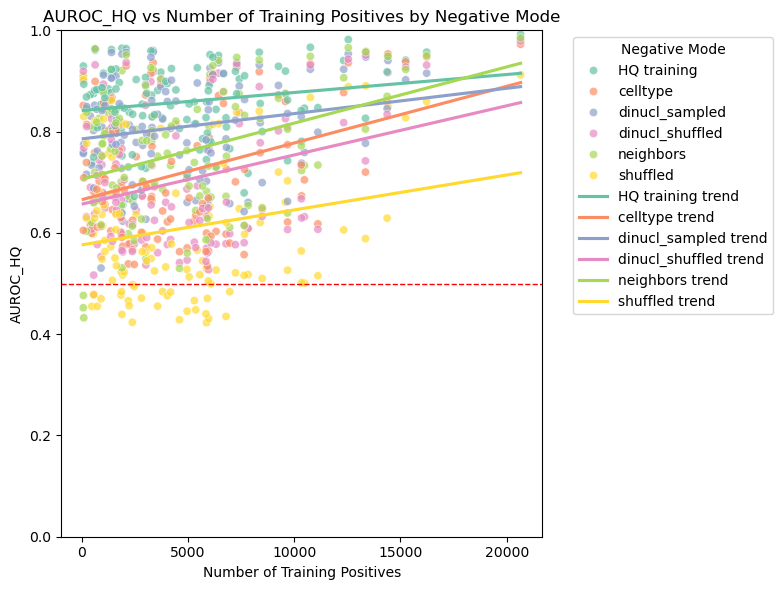

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=grouped_avg,
    x="num_training_positives",
    y="AUROC_HQ",
    hue="neg_mode",
    palette="Set2",
    alpha=0.7
)

# Add trend lines for each neg_mode
for neg_mode, color in zip(grouped_avg["neg_mode"].unique(), sns.color_palette("Set2")):
    subset = grouped_avg[grouped_avg["neg_mode"] == neg_mode]
    sns.regplot(
        data=subset,
        x="num_training_positives",
        y="AUROC_HQ",
        scatter=False,
        color=color,
        label=f"{neg_mode} trend",
        ci=None
    )
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
plt.ylim(0, 1)
plt.xlabel("Number of Training Positives")
plt.ylabel("AUROC_HQ")
plt.title("AUROC_HQ vs Number of Training Positives by Negative Mode")
plt.legend(title="Negative Mode", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# FINAL FIGURES???

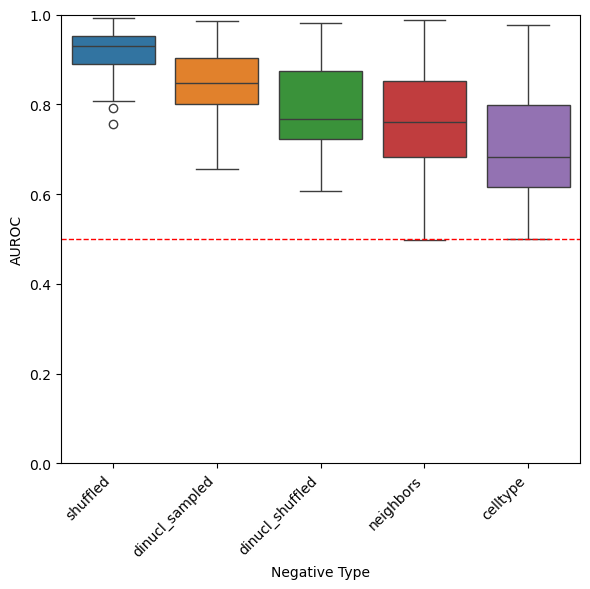

In [62]:
# Compute mean AUROC per neg_mode (excluding HQ training)
mean_auroc_per_mode = (
    grouped_avg[grouped_avg["neg_mode"] != "HQ training"]
    .groupby("neg_mode")["AUROC"]
    .mean()
    .sort_values(ascending=False)
)
neg_mode_order = mean_auroc_per_mode.index.tolist()

# Set categorical order for plotting
plot_df = grouped_avg[grouped_avg["neg_mode"] != "HQ training"].copy()
plot_df["neg_mode"] = pd.Categorical(plot_df["neg_mode"], categories=neg_mode_order, ordered=True)

plt.figure(figsize=(6, 6))
sns.boxplot(data=plot_df, x='neg_mode', y='AUROC', hue='neg_mode')
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Negative Type')
plt.tight_layout()
plt.show()

In [63]:
melted_group_avg = pd.melt(
    grouped_avg[grouped_avg["neg_mode"]!="HQ training"].sort_values(by=['TF-neg_mode']),
    id_vars=['neg_mode', "celltype", 'TF'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_group_avg['auroc_metric'] = melted_group_avg['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})


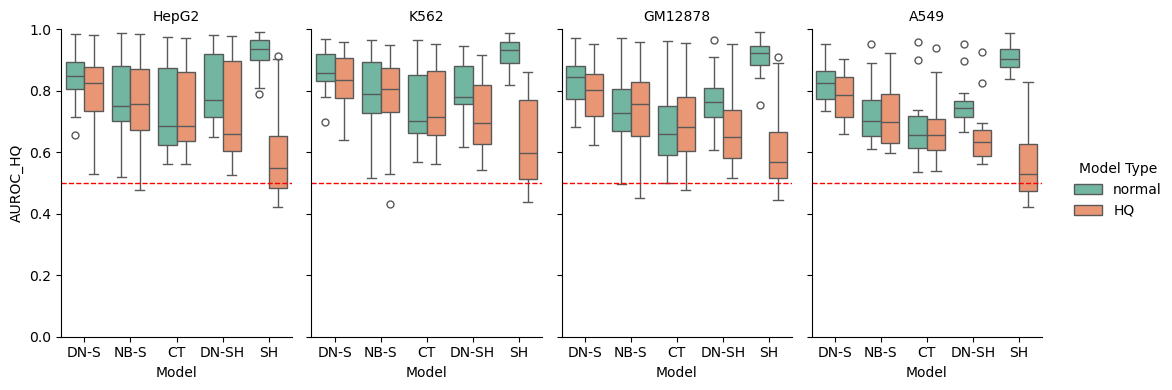

In [64]:
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH',
    'motif': "MOTIF",
    'celltype': 'CT',
    'HQ training': 'HQ'
}
melted_group_avg['neg_mode_short'] = melted_group_avg['neg_mode'].map(neg_mode_labels)
# Only use HQ rows for ordering
hq_rows = melted_group_avg[melted_group_avg['auroc_metric'] == 'HQ']
mean_per_mode = hq_rows.groupby("neg_mode_short")["AUROC_value"].mean().sort_values(ascending=False)
neg_mode_order = mean_per_mode.index.tolist()

# Set categorical order for plotting
melted_group_avg["neg_mode_short"] = pd.Categorical(melted_group_avg["neg_mode_short"], categories=neg_mode_order, ordered=True)



g = sns.catplot(
    data=melted_group_avg,
    x='neg_mode_short',
    col='celltype',
    y='AUROC_value',
    hue='auroc_metric',
    kind='box',
    height=4,
    aspect=0.6,
    palette='Set2'
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Model", "AUROC_HQ")
g._legend.set_bbox_to_anchor((1, 0.5))
g._legend.set_loc("center left")
g._legend.set_title("Model Type")
g.set(ylim=(0, 1))
for ax, celltype in zip(g.axes.flatten(), g.col_names):
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)

plt.tight_layout()
plt.show()


In [65]:
results_df["AUROC_delta"] = results_df["AUROC"] - results_df["AUROC_HQ"]
results_df

,run_name,TF,celltype,neg_mode,cross_val_set,group_name,AUROC,AUROC_HQ,val_loss,celltype_TF,TF-neg_mode,TF-neg_mode-celltype,AUROC_delta,num_training_positives
96,clear-shape-5260,CTCF,GM12878,dinucl_sampled,0.0,full_run_2,0.969141,0.952979,0.426934,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.016162,12222
97,driven-rain-5261,CTCF,GM12878,dinucl_sampled,1.0,full_run_2,0.961291,0.925307,0.522846,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.035984,12222
98,dandy-serenity-5262,CTCF,GM12878,dinucl_sampled,2.0,full_run_2,0.975019,0.960630,0.426776,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.014388,12053
99,good-thunder-5263,CTCF,GM12878,dinucl_sampled,3.0,full_run_2,0.968358,0.928841,0.440390,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.039517,12053
100,whole-pond-5264,CTCF,GM12878,dinucl_sampled,4.0,full_run_2,0.980562,0.963547,0.215077,GM12878_CTCF,CTCF_dinucl_sampled,CTCF_dinucl_sampled_GM12878,0.017015,15832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4459,A549_FOXA1_(SC-101058)_CV1_20250619_02:36,FOXA1_(SC-101058),A549,HQ training,1.0,full_run_3_HQ,NaN,0.907562,0.457816,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549,NaN,2180
4460,A549_FOXA1_(SC-101058)_CV2_20250619_02:36,FOXA1_(SC-101058),A549,HQ training,2.0,full_run_3_HQ,NaN,0.902594,0.542374,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549,NaN,2119
4461,A549_FOXA1_(SC-101058)_CV3_20250619_02:36,FOXA1_(SC-101058),A549,HQ training,3.0,full_run_3_HQ,NaN,0.912508,0.418853,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549,NaN,2119
4462,A549_FOXA1_(SC-101058)_CV4_20250619_02:37,FOXA1_(SC-101058),A549,HQ training,4.0,full_run_3_HQ,NaN,0.912237,0.496110,A549_FOXA1_(SC-101058),FOXA1_(SC-101058)_HQ training,FOXA1_(SC-101058)_HQ training_A549,NaN,3401


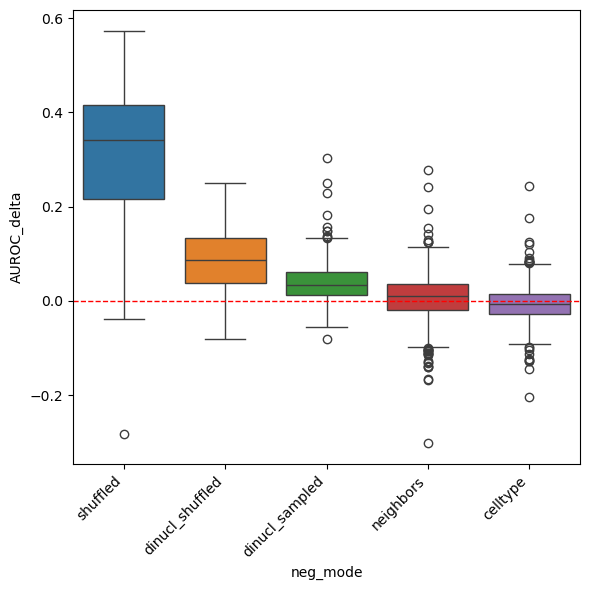

In [66]:
# Compute mean AUROC_delta per neg_mode (excluding HQ training)
mean_delta_per_mode = (
    results_df[results_df["neg_mode"] != "HQ training"]
    .groupby("neg_mode")["AUROC_delta"]
    .mean()
    .sort_values(ascending=False)
)
neg_mode_order = mean_delta_per_mode.index.tolist()

# Set categorical order for plotting
plot_df = results_df[results_df["neg_mode"] != "HQ training"].copy()
plot_df["neg_mode"] = pd.Categorical(plot_df["neg_mode"], categories=neg_mode_order, ordered=True)

plt.figure(figsize=(6, 6))
sns.boxplot(data=plot_df, x='neg_mode', y='AUROC_delta', hue='neg_mode')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [81]:
import os

# Define the folder path
folder_path = "/data/home/natant/Negatives/Runs/full_run_1/motifs"

# Get a list of all CSV files in the folder, excluding HEK293 and MCF-7
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and f not in ['HEK293.csv', 'MCF-7.csv']]

# Load each CSV file into a dictionary of DataFrames
dataframes = {os.path.splitext(f)[0]: pd.read_csv(os.path.join(folder_path, f)) for f in csv_files}
dataframes = {name: df.rename(columns={"Unnamed: 0": "TF"}) for name, df in dataframes.items()}

# Print the names of the loaded DataFrames
print(f"Loaded DataFrames: {list(dataframes.keys())}")

Loaded DataFrames: ['A549', 'GM12878', 'K562', 'HepG2']


In [82]:
# Initialize an empty list to store DataFrames
merged_dfs = []

# Iterate through the CSV files and process each one
for celltype in csv_files:
    # Extract the cell type name (without the .csv extension)
    celltype_name = os.path.splitext(celltype)[0]
    
    # Load the DataFrame for the current cell type
    df = pd.melt(
        dataframes[celltype_name],
        id_vars=['TF'],
        value_vars=['AUROC_1', 'AUROC_2', 'AUROC_3'],
        value_name='AUROC'
    )
    
    # Drop unnecessary columns and rows with NaN values
    df = df.dropna().drop(columns=['variable'])
    
    # Add additional columns for cell type and neg_mode
    df['celltype'] = celltype_name
    df['neg_mode'] = 'motif'
    
    # Append the processed DataFrame to the list
    merged_dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
motif_df = pd.concat(merged_dfs, ignore_index=True)

In [83]:
# Find TFs in results_df that are not present in motif_df for each celltype
motif_celltypes = motif_df["celltype"].unique()
motif_tfs = motif_df["TF"].unique()

# For each celltype, report missing TFs
report = {}
for ct in motif_celltypes:
    tfs_in_results = set(results_df[results_df["celltype"] == ct]["TF"].unique())
    tfs_in_motif = set(motif_df[motif_df["celltype"] == ct]["TF"].unique())
    missing_tfs = tfs_in_results - tfs_in_motif
    report[ct] = {
        "total_TFs_in_results": len(tfs_in_results),
        "TFs_with_motif": len(tfs_in_motif),
        "TFs_missing_motif": len(missing_tfs),
        "missing_TFs": list(missing_tfs)
    }

# Print the report
for ct, stats in report.items():
    print(f"Celltype: {ct}")
    print(f"  Total TFs in results_df: {stats['total_TFs_in_results']}")
    print(f"  TFs with motif: {stats['TFs_with_motif']}")
    print(f"  TFs missing motif: {stats['TFs_missing_motif']}")
    print(f"  Missing TFs: {stats['missing_TFs']}\n")

# How many rows are removed from results_df when subsetting to TFs and celltypes present in motif_df
initial_rows = results_df.shape[0]
subset_df = results_df[(results_df['celltype'].isin(motif_celltypes)) & (results_df['TF'].isin(motif_tfs))]
removed_rows = initial_rows - subset_df.shape[0]
print(f"Rows in results_df before subsetting: {initial_rows}")
print(f"Rows in results_df after subsetting: {subset_df.shape[0]}")
print(f"Rows removed: {removed_rows}")

Celltype: A549
  Total TFs in results_df: 14
  TFs with motif: 12
  TFs missing motif: 2
  Missing TFs: ['SIX5', 'USF-1']

Celltype: GM12878
  Total TFs in results_df: 36
  TFs with motif: 30
  TFs missing motif: 6
  Missing TFs: ['TBP', 'ZZZ3', 'STAT5A_(SC-74442)', 'SIX5', 'USF-1', 'RXRA']

Celltype: K562
  Total TFs in results_df: 36
  TFs with motif: 30
  TFs missing motif: 6
  Missing TFs: ['TBP', 'SETDB1', 'ATF1_(06-325)', 'STAT5A_(SC-74442)', 'SIX5', 'USF-1']

Celltype: HepG2
  Total TFs in results_df: 33
  TFs with motif: 30
  TFs missing motif: 4
  Missing TFs: ['TBP', 'USF-1', 'RXRA', 'ARID3A_(NB100-279)']

Rows in results_df before subsetting: 4284
Rows in results_df after subsetting: 3636
Rows removed: 648


In [84]:
subset_df = grouped_avg[(grouped_avg['celltype'].isin(motif_df["celltype"].unique())) & (grouped_avg['TF'].isin(motif_df['TF'].unique()))]
# Concatenate subset_df and melted_df, keeping only the specified columns
subset_df = subset_df[['TF', 'AUROC_HQ', 'neg_mode', 'celltype']]
motif_df = motif_df.rename(columns={"AUROC": "AUROC_HQ"})
fused_df = pd.concat([subset_df[['TF', 'AUROC_HQ', 'neg_mode', 'celltype']], motif_df[['TF', 'AUROC_HQ', 'neg_mode', 'celltype']]])

# Reset the index for the new DataFrame
fused_df.reset_index(drop=True, inplace=True)


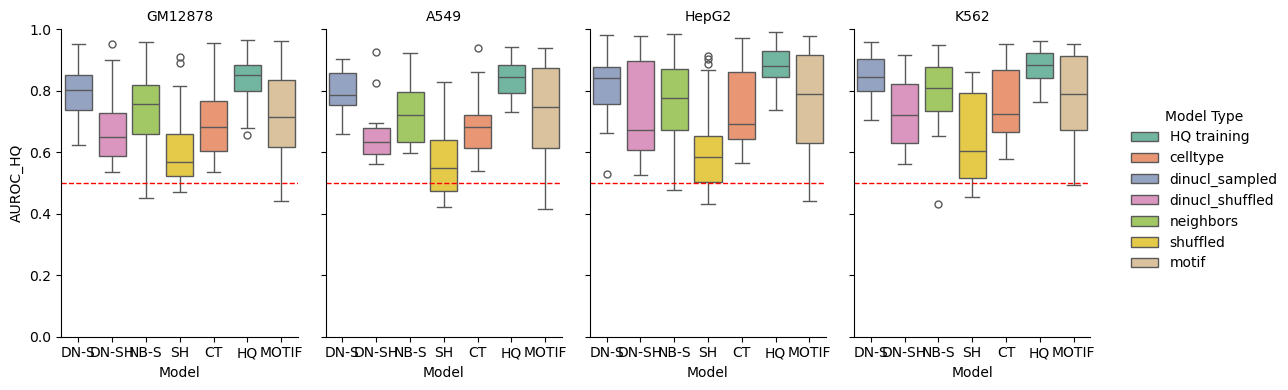

In [85]:
# Shorten neg_mode labels
neg_mode_labels = {
    'dinucl_sampled': 'DN-S',
    'dinucl_shuffled': 'DN-SH',
    'neighbors': 'NB-S',
    'shuffled': 'SH',
    'motif': "MOTIF",
    'celltype': 'CT',
    'HQ training': 'HQ'
}

# Apply and order short labels
fused_df['neg_mode_short'] = fused_df['neg_mode'].map(neg_mode_labels)
neg_mode_order = ['DN-S', 'DN-SH', 'NB-S', 'SH', 'CT', 'HQ', 'MOTIF']
fused_df['neg_mode_short'] = pd.Categorical(fused_df['neg_mode_short'], categories=neg_mode_order, ordered=True)

g = sns.catplot(
        data=fused_df,
        x='neg_mode_short',
        col='celltype',
        y='AUROC_HQ',
        hue='neg_mode',
        kind='box',
        height=4,
        aspect=0.6,
        palette='Set2'
    )
# Titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Model", "AUROC_HQ")

# Fix x-tick rotation manually
# for ax in g.axes.flatten():
#     for label in ax.get_xticklabels():
#         label.set_rotation(90)
#     ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
# Adjust legend placement to avoid overlapping
g._legend.set_bbox_to_anchor((1, 0.5))
g._legend.set_loc("center left")
# Rename the legend title
g._legend.set_title("Model Type")

# Scale the y-axis from 0 to 1
g.set(ylim=(0, 1))

# Add a red line at y=0.5
for ax in g.axes.flatten():
    ax.axhline(0.5, linestyle='--', color='red', linewidth=1)
plt.tight_layout()
plt.show()

In [87]:
grouped_avg[(grouped_avg["neg_mode"] == "shuffled") & (grouped_avg["celltype"] == "A549")]

,TF,celltype,neg_mode,AUROC,AUROC_HQ,num_training_positives,TF-neg_mode,neg_mode_short
23,ATF3,A549,shuffled,0.838427,0.465908,2196.000000,ATF3-shuffled,SH
47,BHLHE40,A549,shuffled,0.895226,0.655250,1041.666667,BHLHE40-shuffled,SH
89,CREB1_(SC-240),A549,shuffled,0.879060,0.466267,5302.333333,CREB1_(SC-240)-shuffled,SH
95,CTCF,A549,shuffled,0.987697,0.827190,15245.000000,CTCF-shuffled,SH
119,ELF1_(SC-631),A549,shuffled,0.923393,0.600389,2872.666667,ELF1_(SC-631)-shuffled,SH
155,ETS1,A549,shuffled,0.864337,0.477217,1847.000000,ETS1-shuffled,SH
191,FOSL2,A549,shuffled,0.973430,0.660690,9587.666667,FOSL2-shuffled,SH
203,FOXA1_(SC-101058),A549,shuffled,0.970084,0.636482,2566.666667,FOXA1_(SC-101058)-shuffled,SH
317,Max,A549,shuffled,0.889274,0.570601,3297.000000,Max-shuffled,SH
461,SIX5,A549,shuffled,0.868424,0.535347,1638.333333,SIX5-shuffled,SH


In [93]:
results_df[(results_df["neg_mode"] == "shuffled") & (results_df["celltype"] == "A549") & (results_df["cross_val_set"]== 0.)]

,run_name,TF,celltype,neg_mode,cross_val_set,group_name,AUROC,AUROC_HQ,val_loss,celltype_TF,TF-neg_mode,TF-neg_mode-celltype,AUROC_delta,num_training_positives
2700,ethereal-mountain-7864,CTCF,A549,shuffled,0.0,full_run_2,0.992263,0.878274,0.139122,A549_CTCF,CTCF_shuffled,CTCF_shuffled_A549,0.113989,13342
2724,soft-music-7888,YY1_(SC-281),A549,shuffled,0.0,full_run_2,0.899773,0.503871,0.983078,A549_YY1_(SC-281),YY1_(SC-281)_shuffled,YY1_(SC-281)_shuffled_A549,0.395902,2807
2748,trim-butterfly-7912,CREB1_(SC-240),A549,shuffled,0.0,full_run_2,0.903380,0.497490,0.519955,A549_CREB1_(SC-240),CREB1_(SC-240)_shuffled,CREB1_(SC-240)_shuffled_A549,0.405890,4496
2772,restful-moon-7936,Max,A549,shuffled,0.0,full_run_2,0.905990,0.649451,0.920921,A549_Max,Max_shuffled,Max_shuffled_A549,0.256539,2668
2796,twilight-snowball-7960,TCF12,A549,shuffled,0.0,full_run_2,0.945036,0.482181,0.391274,A549_TCF12,TCF12_shuffled,TCF12_shuffled_A549,0.462855,5817
2820,dauntless-dust-7984,FOSL2,A549,shuffled,0.0,full_run_2,0.970771,0.629572,0.412217,A549_FOSL2,FOSL2_shuffled,FOSL2_shuffled_A549,0.341198,7796
2844,fast-wood-8008,ELF1_(SC-631),A549,shuffled,0.0,full_run_2,0.912759,0.588491,0.543316,A549_ELF1_(SC-631),ELF1_(SC-631)_shuffled,ELF1_(SC-631)_shuffled_A549,0.324268,2357
2868,upbeat-eon-8032,BHLHE40,A549,shuffled,0.0,full_run_2,0.907408,0.666631,0.522819,A549_BHLHE40,BHLHE40_shuffled,BHLHE40_shuffled_A549,0.240777,850
2892,super-violet-8056,ATF3,A549,shuffled,0.0,full_run_2,0.902734,0.440649,0.503246,A549_ATF3,ATF3_shuffled,ATF3_shuffled_A549,0.462085,1631
2916,dazzling-bush-8080,USF-1,A549,shuffled,0.0,full_run_2,0.929634,0.476241,0.401013,A549_USF-1,USF-1_shuffled,USF-1_shuffled_A549,0.453393,2170
